In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("talk")

## Load Data


According to Kenny, the best days are Bond day 8, epoch 4, and Frank day 6, epoch 4.

In [3]:
from src.load_data import load_data

epoch_key = ("bon", 8, 4)

data = load_data(epoch_key)

Failed to load file: /home/edeno/Documents/Github/replicate_kenny_analysis/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/edeno/Documents/Github/replicate_kenny_analysis/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/edeno/Documents/Github/replicate_kenny_analysis/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/edeno/Documents/Github/replicate_kenny_analysis/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/edeno/Documents/Github/replicate_kenny_analysis/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/edeno/Documents/Github/replicate_kenny_analysis/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, i

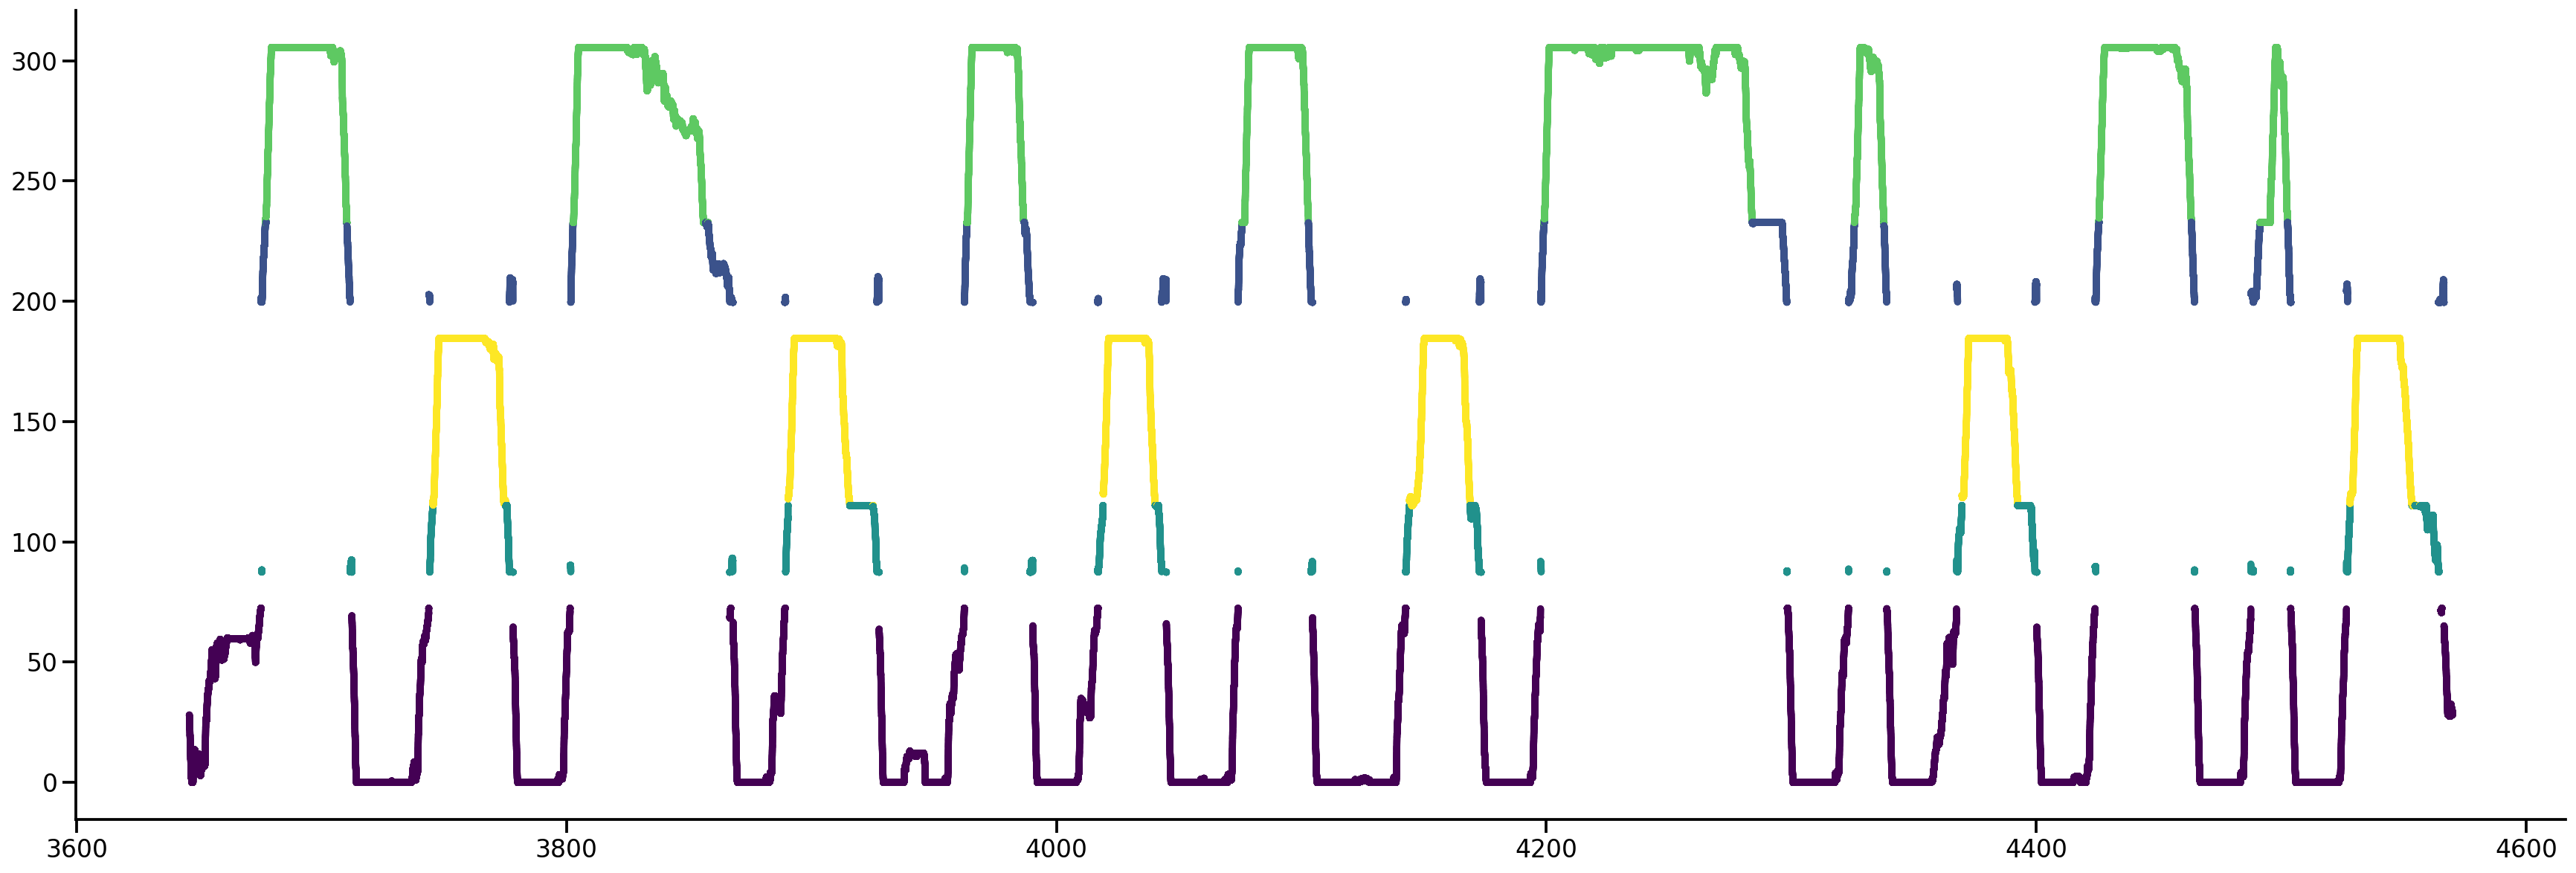

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

ax.scatter(
    data["position_info"].index / np.timedelta64(1, "s"),
    data["position_info"].linear_position,
    c=data["position_info"].track_segment_id,
    s=10,
)
sns.despine()

In [4]:
is_running = data["position_info"].speed > 4
is_outbound = data["position_info"].task == "Outbound"

track_labels = data["position_info"].arm_name

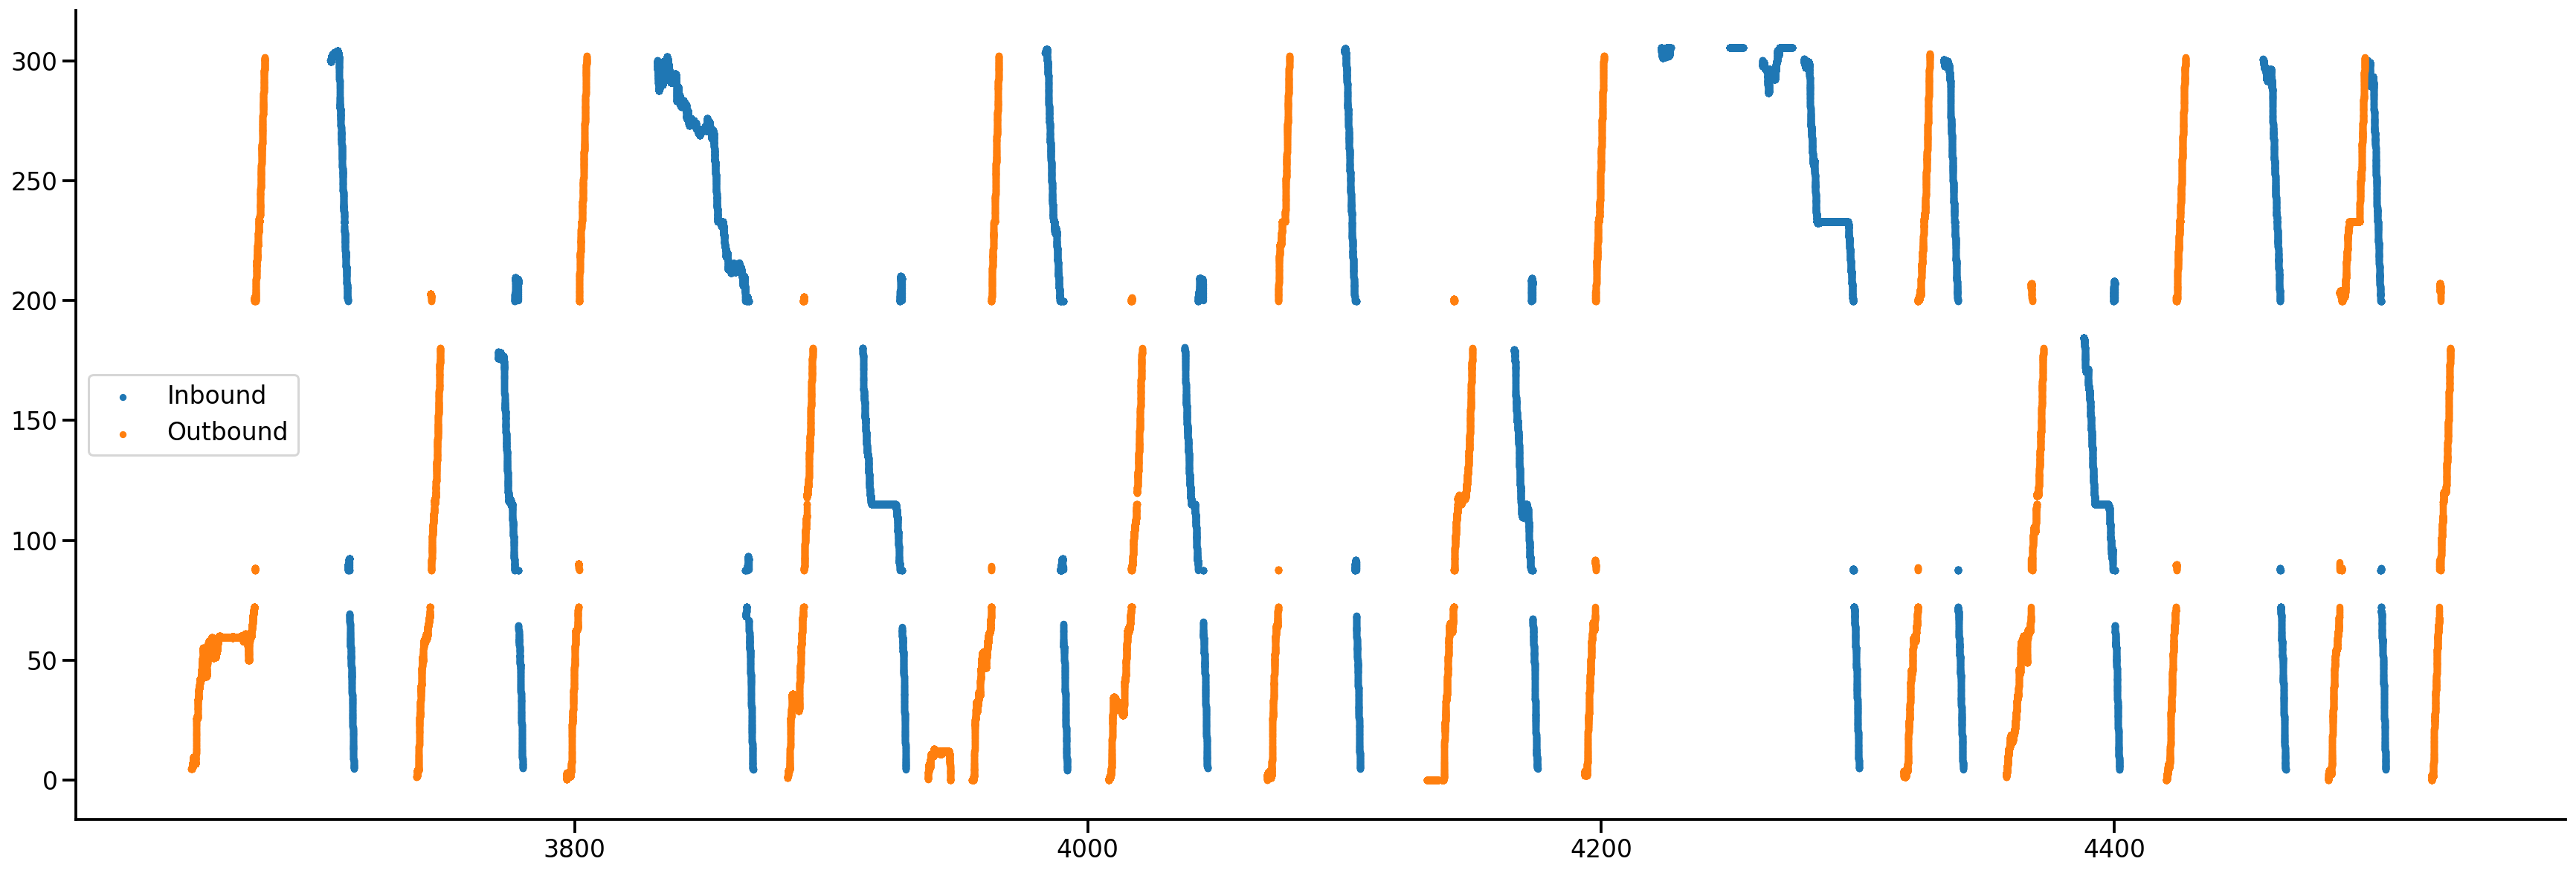

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

for task, df in data["position_info"].groupby("task"):
    ax.scatter(
        df.index / np.timedelta64(1, "s"), df.linear_position, s=10, label=task,
    )

plt.legend()
sns.despine()

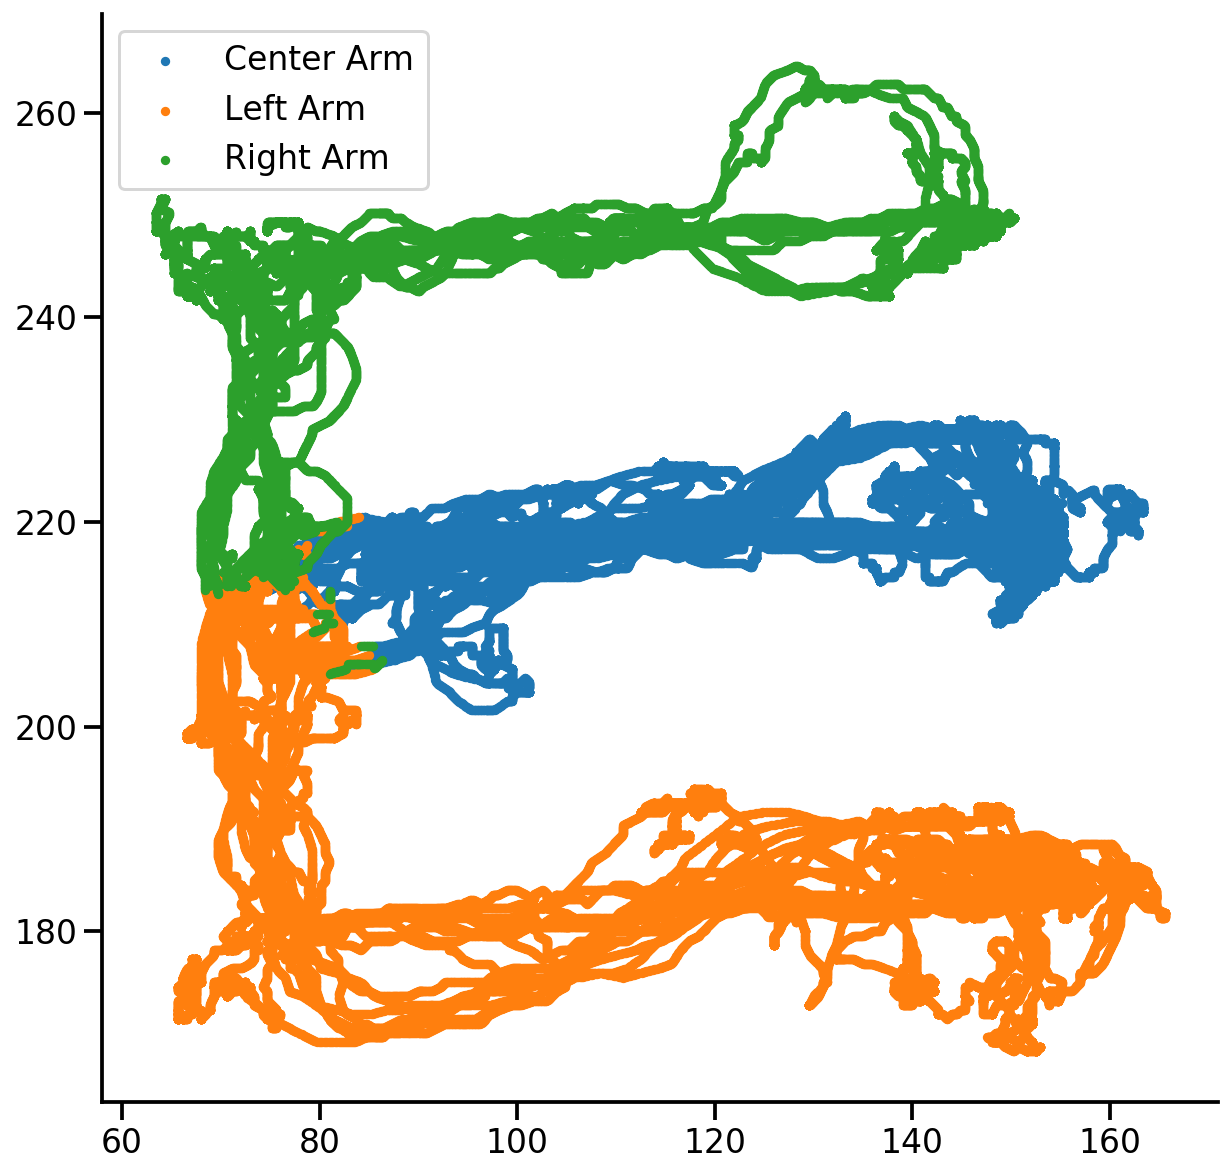

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for task, df in data["position_info"].groupby("arm_name"):
    ax.scatter(
        df.y_position, df.x_position, s=10, label=task,
    )

plt.legend()
sns.despine()

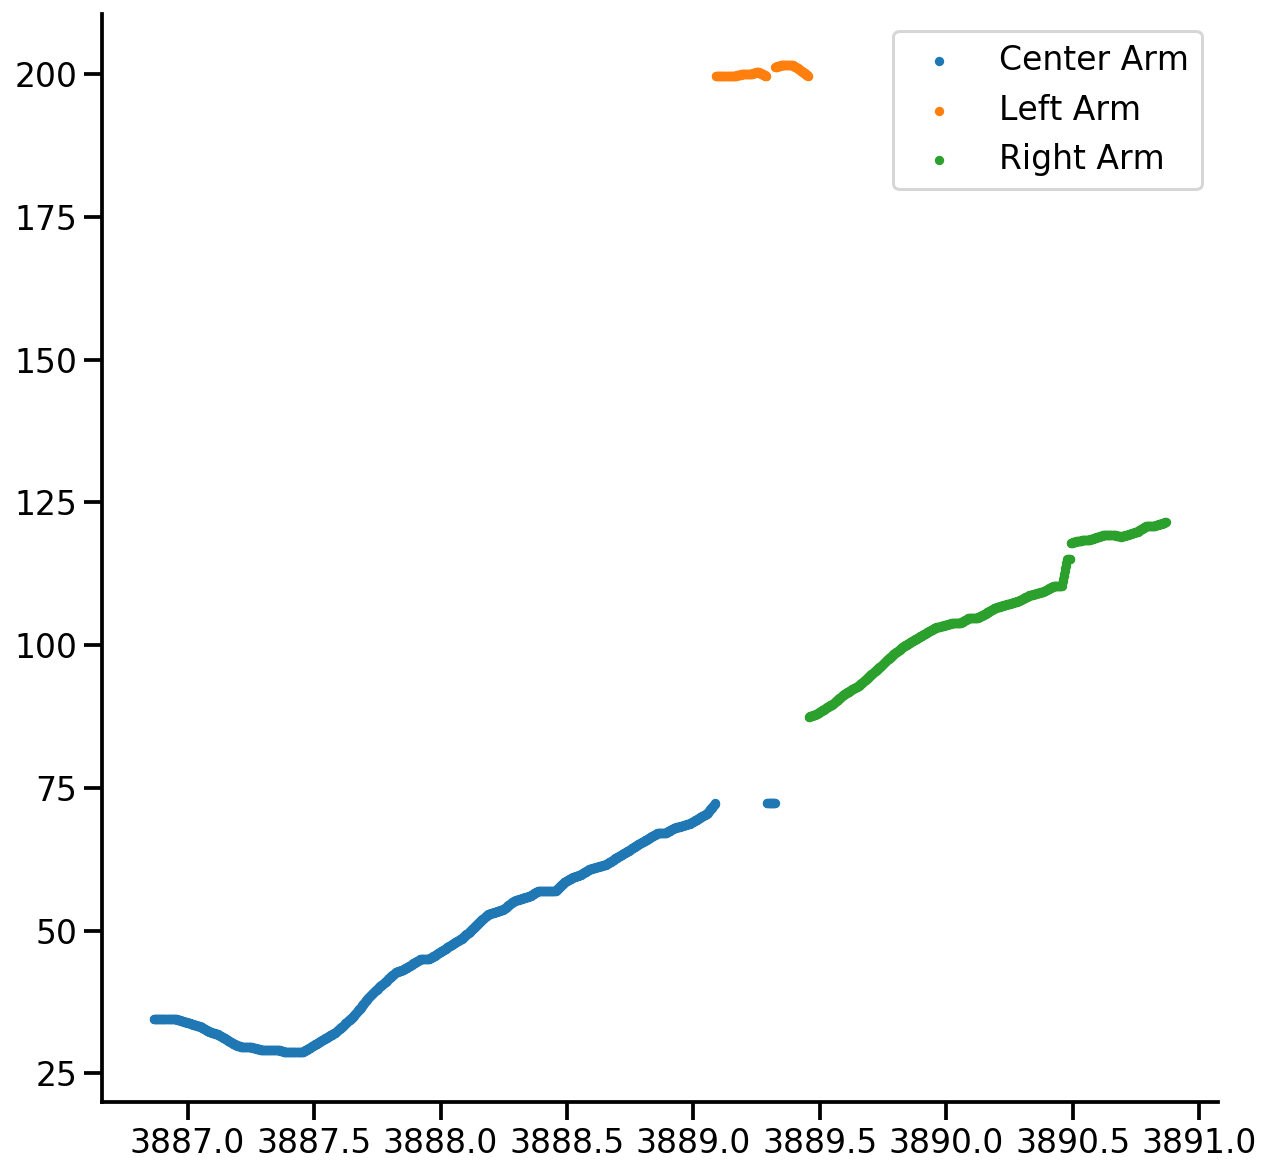

In [20]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 240.85, t.min() + 244.85)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for task, df in (
    data["position_info"].reset_index().set_index(t).loc[time_slice].groupby("arm_name")
):
    ax.scatter(
        df.index, df.linear_position, s=10, label=task,
    )

plt.legend()
sns.despine()

## Local vs. Non-Local

In [7]:
from replay_identification import ReplayDetector
from src.parameters import detector_parameters

detector = ReplayDetector(**detector_parameters)

detector.fit(
    is_ripple=data["is_ripple"],
    speed=data["position_info"].speed,
    position=data["position_info"].linear_position,
    spikes=data["spikes"],
    multiunit=data["multiunit"],
    track_labels=track_labels,
)

ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='constant',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='w_track_1D_random_walk',
               movement_var=25.0,
               multiunit_density_model=<class...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=1.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_mod

In [8]:
spikes_results = detector.predict(
    speed=data["position_info"].speed,
    position=data["position_info"].linear_position,
    spikes=data["spikes"],
    multiunit=data["multiunit"],
    use_likelihoods=["spikes"],
    time=data["position_info"].index / np.timedelta64(1, "s"),
)

In [9]:
spikes_results

<xarray.Dataset>
Dimensions:             (position: 308, state: 2, time: 461997)
Coordinates:
  * time                (time) float64 3.646e+03 3.646e+03 ... 4.57e+03 4.57e+03
  * position            (position) float64 -0.4992 0.4992 1.498 ... 305.0 306.0
  * state               (state) <U9 'No Replay' 'Replay'
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 0.005935
    likelihood          (time, state, position) float64 0.0 0.9513 ... 0.9901
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 0.005935
    replay_probability  (time) float64 0.0 1.462e-05 2.798e-05 ... 0.5712 0.5603

In [10]:
spikes_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_sorted_spikes_results.nc"
)

In [11]:
clusterless_results = detector.predict(
    speed=data["position_info"].speed,
    position=data["position_info"].linear_position,
    spikes=data["spikes"],
    multiunit=data["multiunit"],
    use_likelihoods=["multiunit"],
    time=data["position_info"].index / np.timedelta64(1, "s"),
)

In [12]:
clusterless_results

<xarray.Dataset>
Dimensions:             (position: 308, state: 2, time: 461997)
Coordinates:
  * time                (time) float64 3.646e+03 3.646e+03 ... 4.57e+03 4.57e+03
  * position            (position) float64 -0.4992 0.4992 1.498 ... 305.0 306.0
  * state               (state) <U9 'No Replay' 'Replay'
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 3.661e-06
    likelihood          (time, state, position) float64 0.0 0.8228 ... 0.6898
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 3.661e-06
    replay_probability  (time) float64 0.0 6.027e-06 ... 0.001368 0.001362

In [13]:
clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_clusterless_results.nc"
)

In [14]:
data["position_info"].to_xarray().to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_position_info.nc"
)

In [11]:
def plot_local_non_local_time_slice(
    time_slice,
    detector,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
):
    mask = np.ones_like(detector.is_track_interior_.squeeze(), dtype=np.float)
    mask[~detector.is_track_interior_] = np.nan
    cmap = plt.cm.viridis
    cmap.set_bad("white", alpha=0.0)

    fig, axes = plt.subplots(
        4,
        1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [3, 1, 1, 1]},
    )

    # ax 0
    (results[posterior_type].sel(state="Replay", time=time_slice) * mask).plot(
        x="time", y="position", robust=True, ax=axes[0], cmap=cmap, vmin=0.0,
    )
    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    axes[0].text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[0].set_ylabel("Position [cm]")

    axes[0].set_title("Non-Local Posterior")

    axes[0].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="lightgreen",
        linewidth=5,
        alpha=0.8,
    )
    axes[0].set_xlabel("")

    # ax 1
    results[posterior_type].sum("position").sel(state="Replay", time=time_slice).plot(
        x="time", ax=axes[1]
    )
    axes[1].set_title("Non-Local Probability")
    axes[1].set_ylabel("Probability")
    axes[1].set_xlabel("")

    # ax 2
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )

    axes[2].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[2].set_ylabel("Firing Rate\n[spikes / s]")
    axes[2].set_title("Multiunit")

    # ax 3
    axes[3].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[3].set_ylabel("Speed [cm / s]")
    axes[3].set_xlabel("Time [ms]")
    sns.despine()

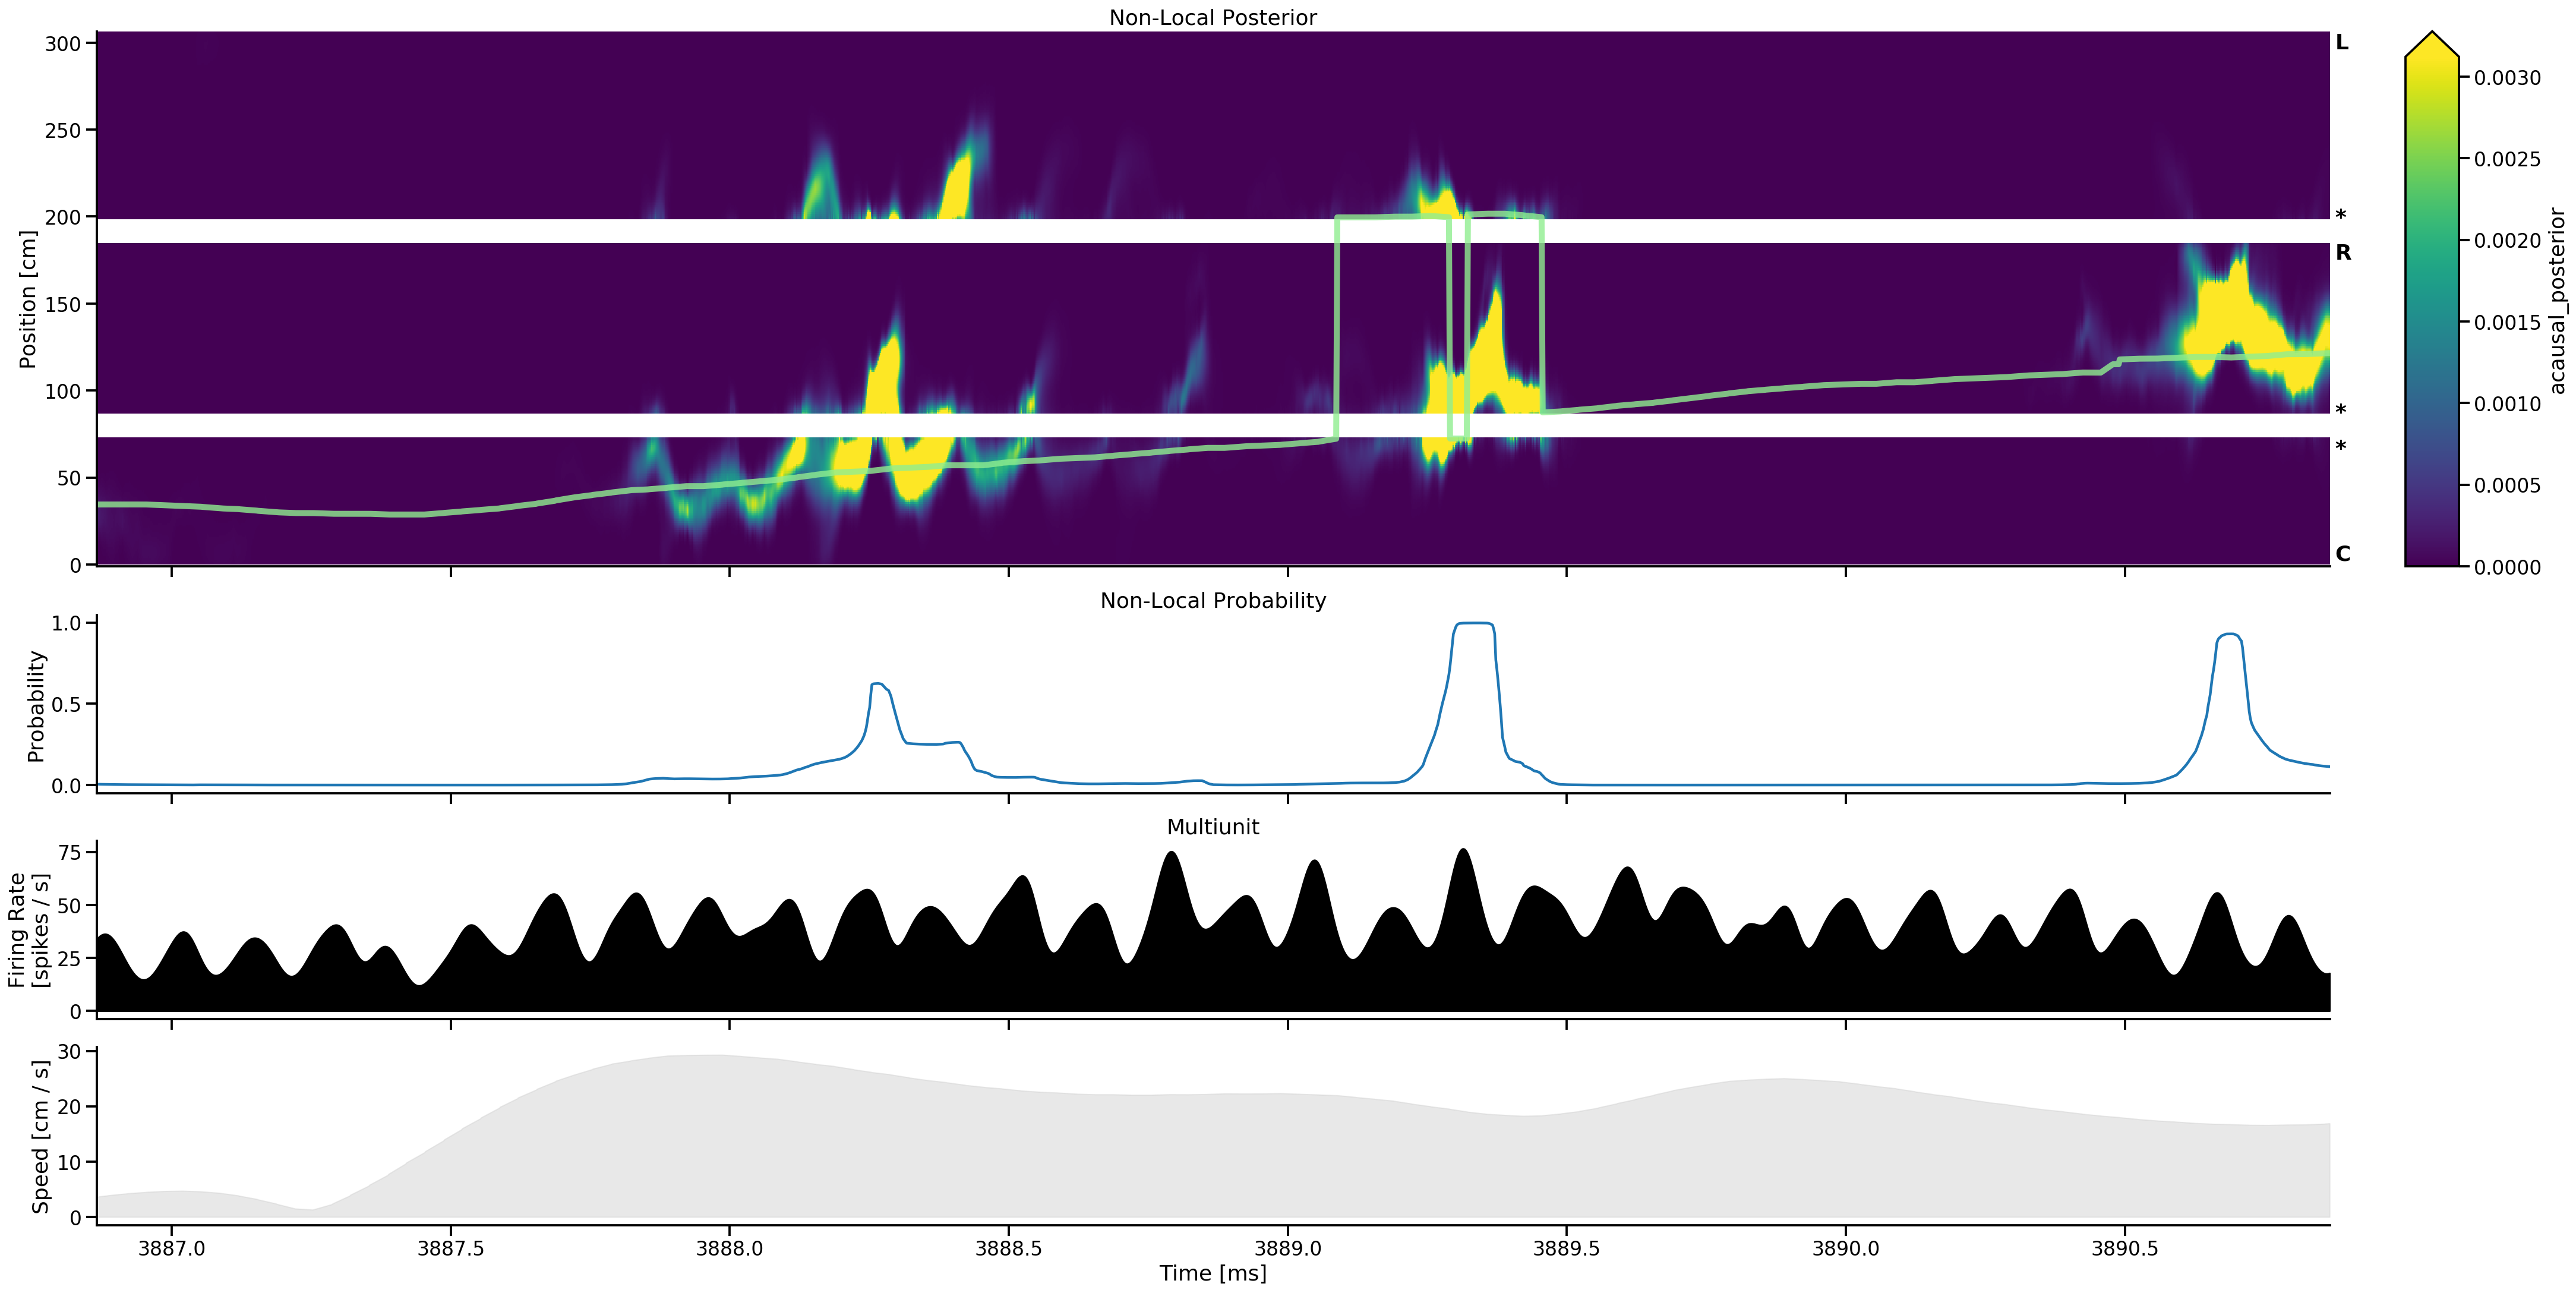

In [137]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 240.85, t.min() + 244.85)

plot_local_non_local_time_slice(time_slice, detector, clusterless_results, data)

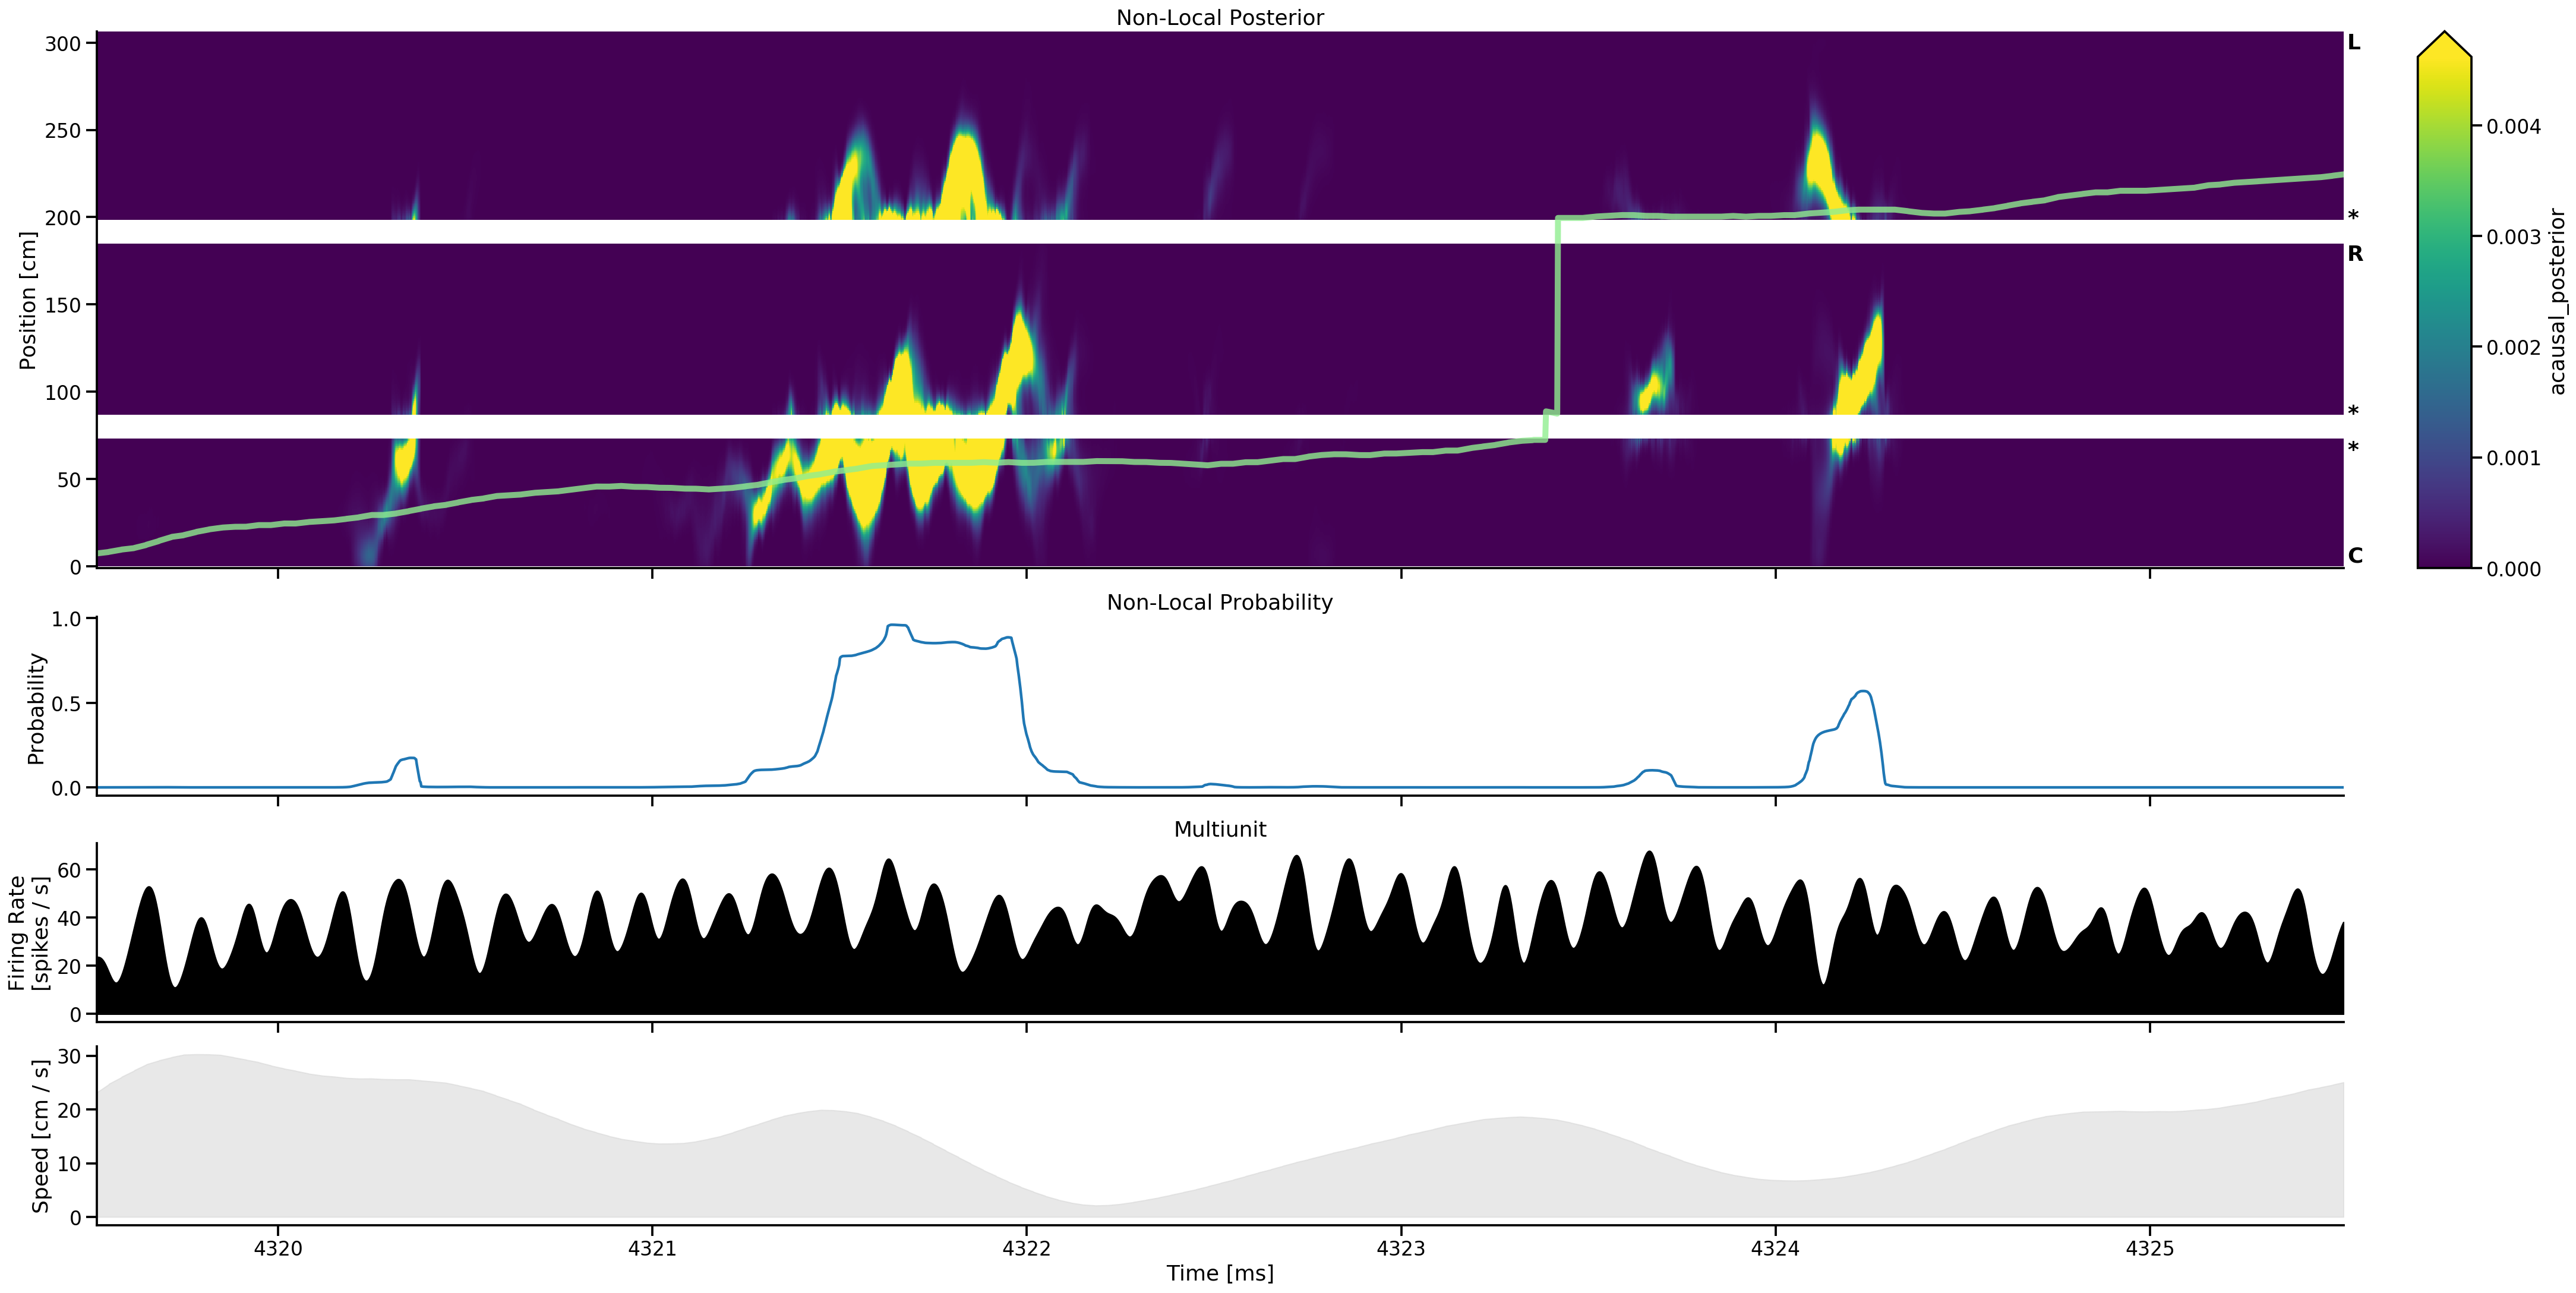

In [138]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 673.5, t.min() + 679.5)

plot_local_non_local_time_slice(time_slice, detector, clusterless_results, data)

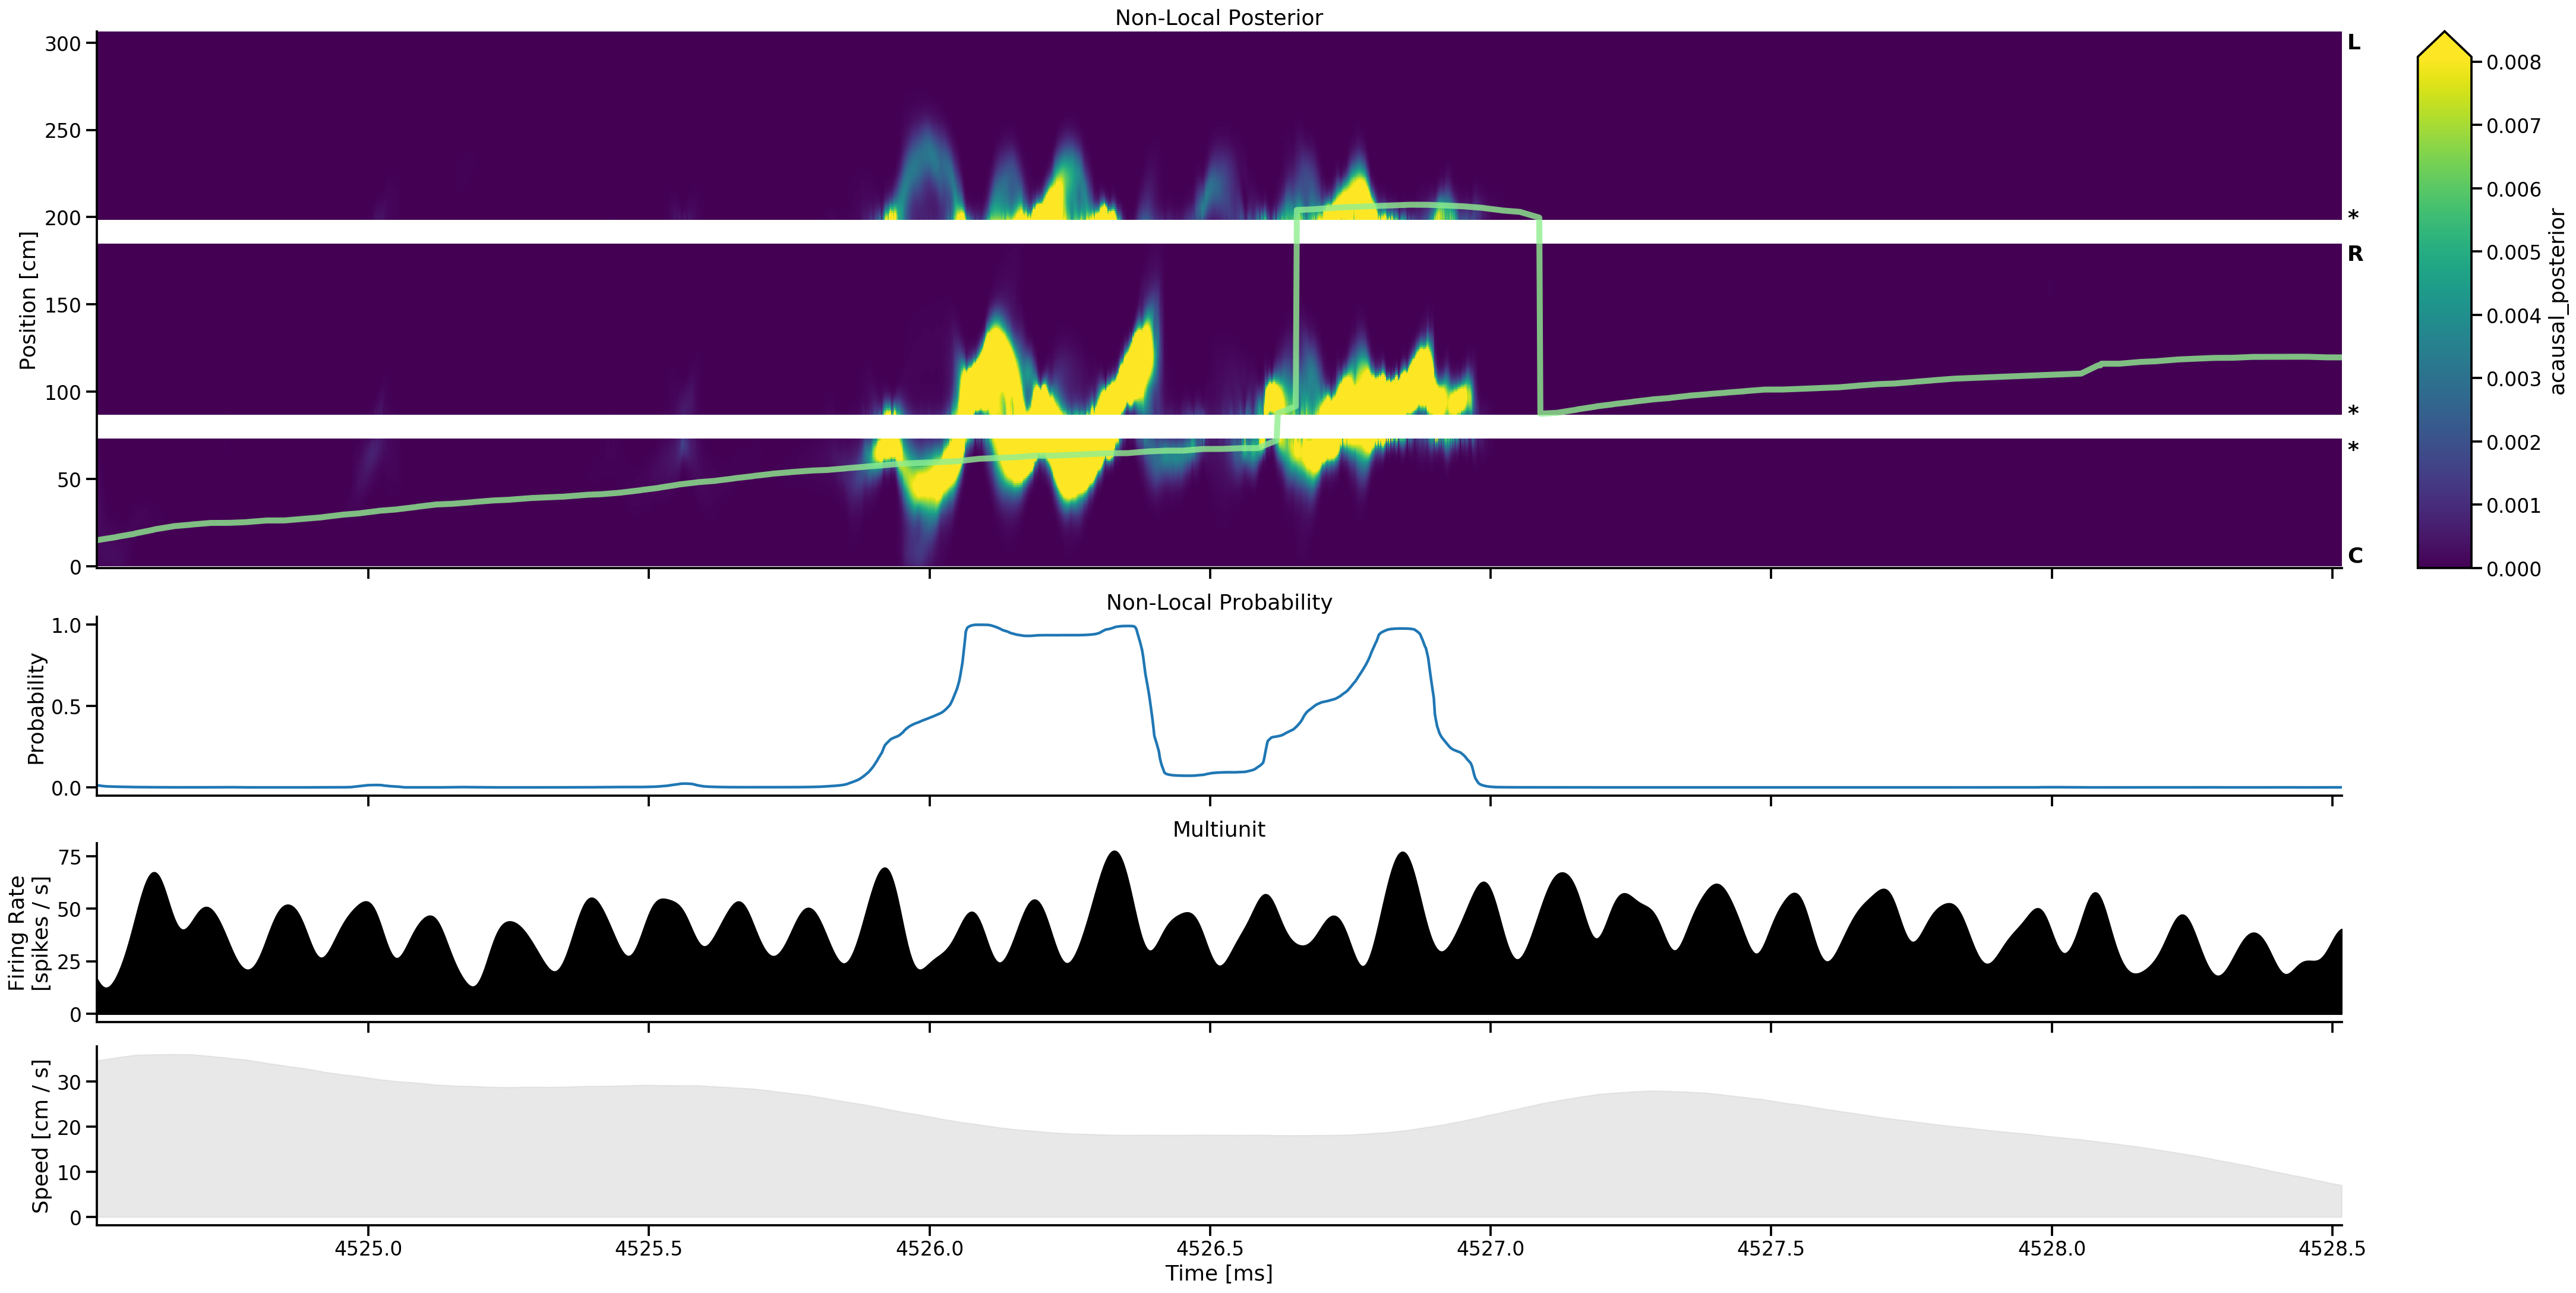

In [139]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 878.5, t.min() + 882.5)

plot_local_non_local_time_slice(time_slice, detector, clusterless_results, data)

## Local vs. Non-Local: cross validate

In [5]:
from replay_identification import ReplayDetector
from src.parameters import detector_parameters
from sklearn.model_selection import KFold

cv = KFold()
cv_clusterless_results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    print(f"Fold={fold_ind}")

    cv_detector = ReplayDetector(**detector_parameters)

    cv_detector.fit(
        is_ripple=data["is_ripple"].iloc[train],
        speed=data["position_info"].iloc[train].speed,
        position=data["position_info"].iloc[train].linear_position,
        multiunit=data["multiunit"].isel(time=train),
        track_labels=track_labels.iloc[train],
    )

    cv_clusterless_results.append(
        cv_detector.predict(
            speed=data["position_info"].iloc[test].speed,
            position=data["position_info"].iloc[test].linear_position,
            multiunit=data["multiunit"].isel(time=test),
            use_likelihoods=["multiunit"],
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )

Fold=0



Fold=1



Fold=2



Fold=3



Fold=4


In [9]:
import xarray as xr

cv_clusterless_results = xr.concat(cv_clusterless_results, dim="time")
cv_clusterless_results

<xarray.Dataset>
Dimensions:             (position: 308, state: 2, time: 461997)
Coordinates:
  * position            (position) float64 -0.4992 0.4992 1.498 ... 305.0 306.0
  * state               (state) <U9 'No Replay' 'Replay'
  * time                (time) float64 3.646e+03 3.646e+03 ... 4.57e+03 4.57e+03
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 4.53e-06
    likelihood          (time, state, position) float64 0.0 0.8085 ... 0.7038
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 4.53e-06
    replay_probability  (time) float64 0.0 1.016e-05 ... 0.002259 0.002236

In [22]:
cv_clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_clusterless_results.nc"
)

#### Plot acausal

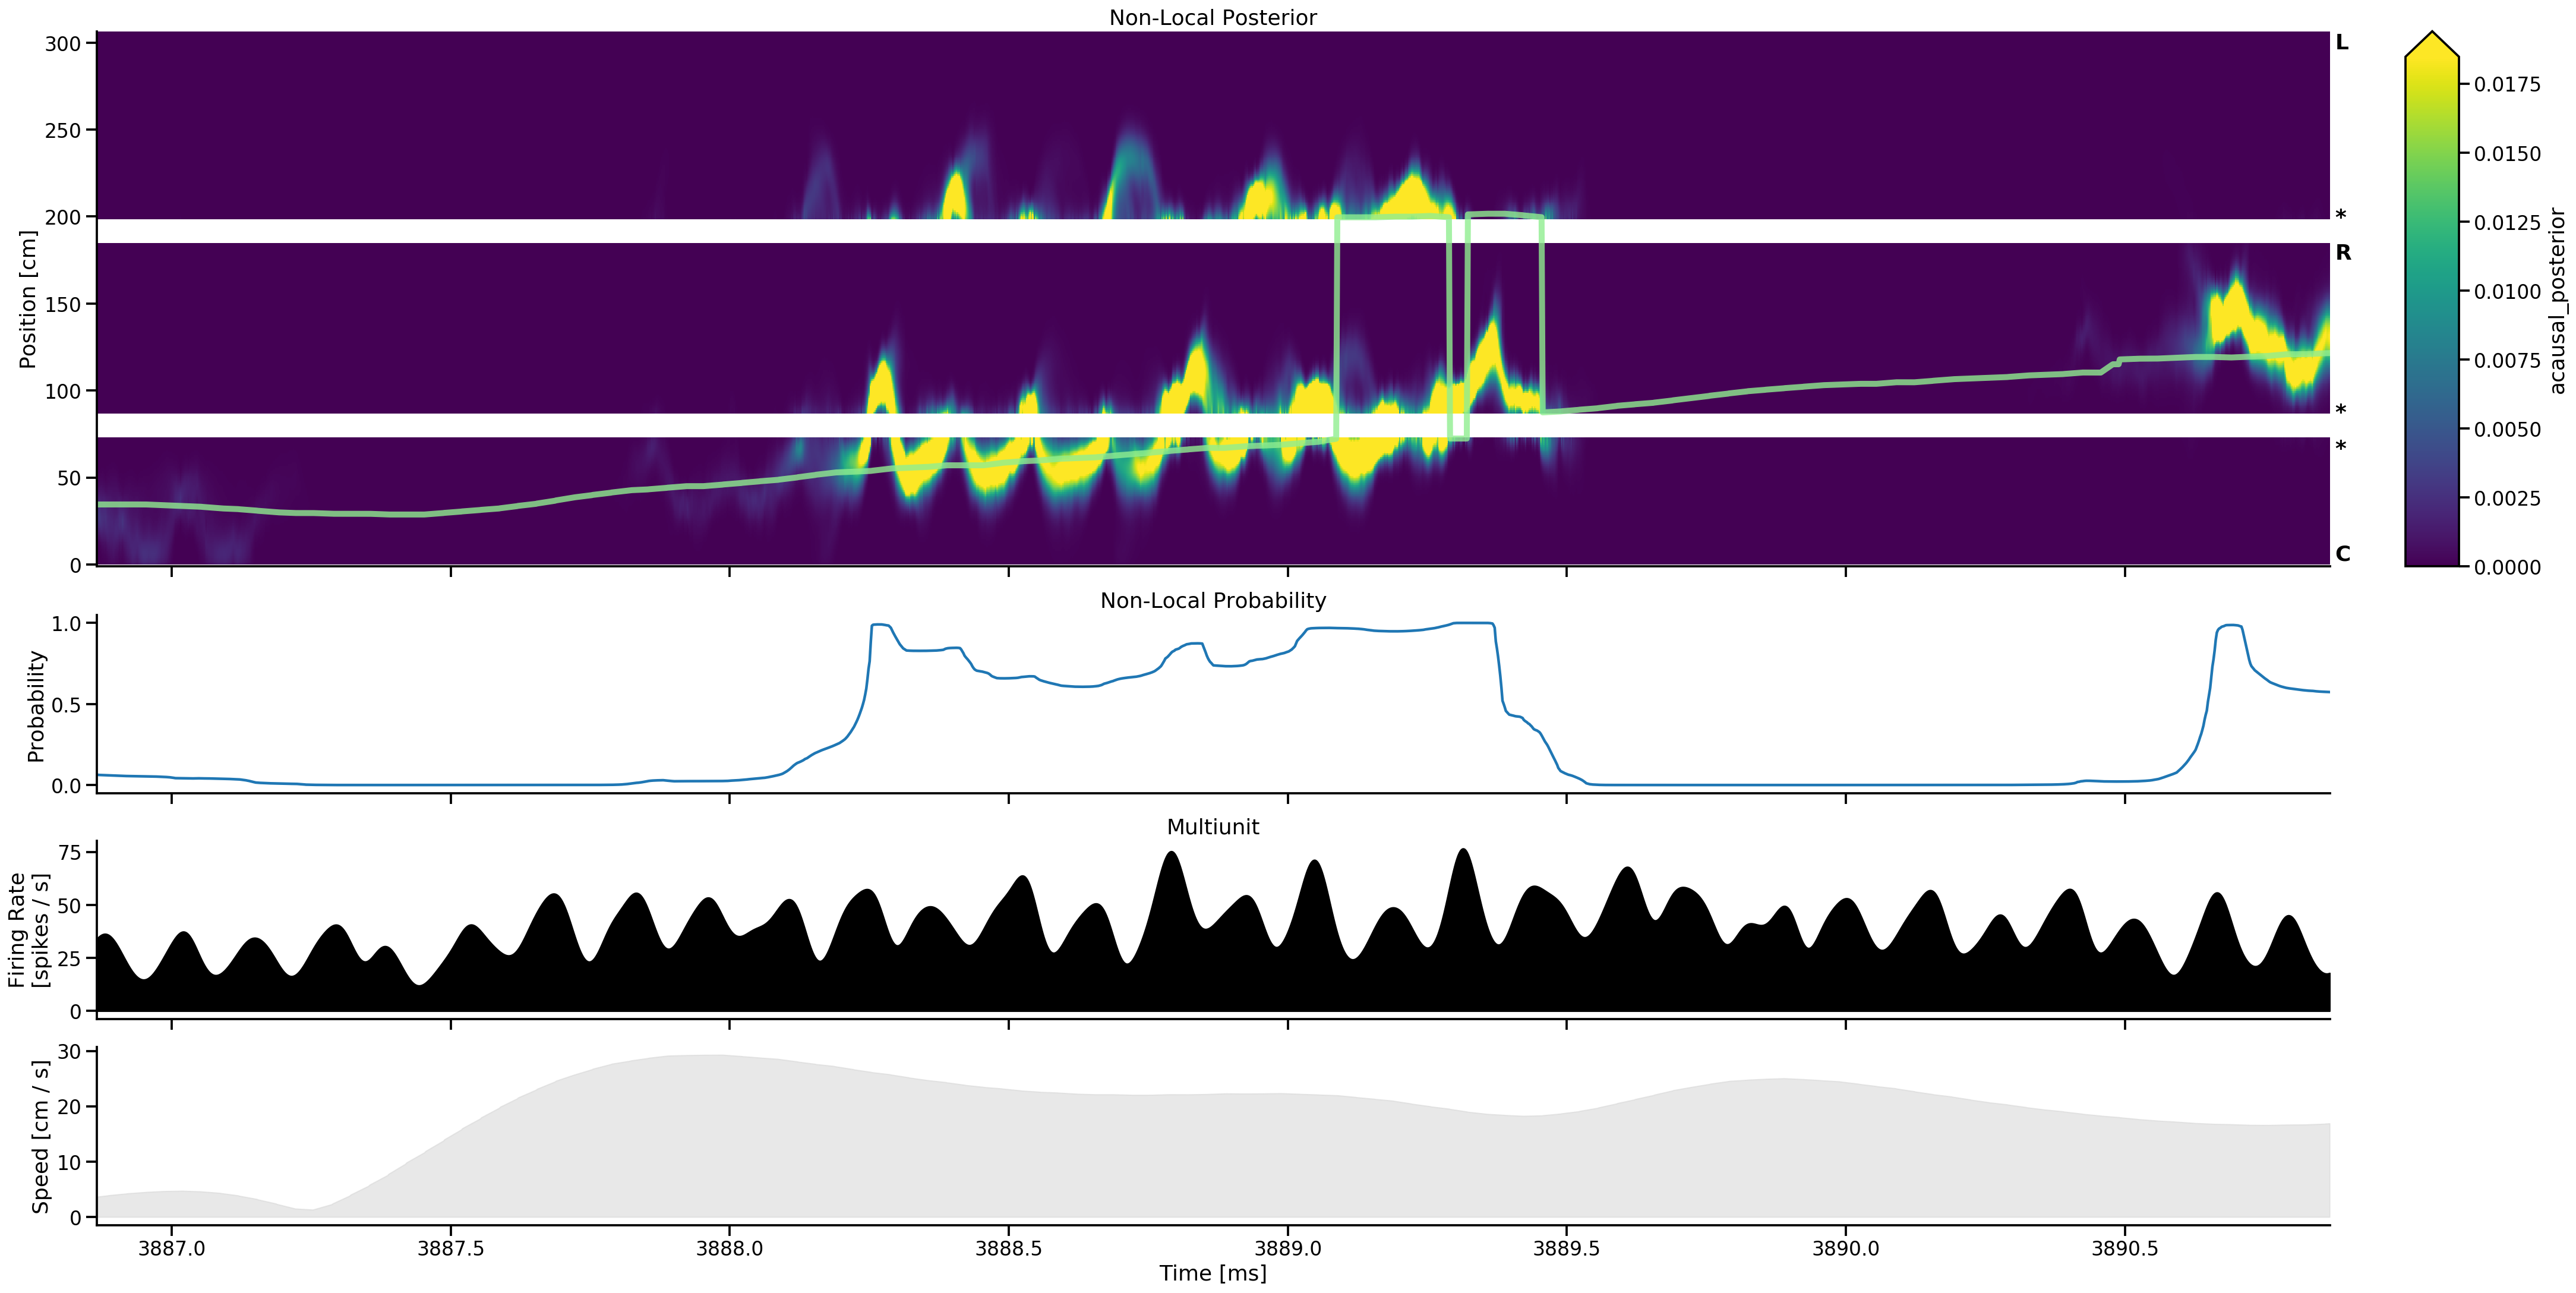

In [12]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 240.85, t.min() + 244.85)

plot_local_non_local_time_slice(time_slice, cv_detector, cv_clusterless_results, data)

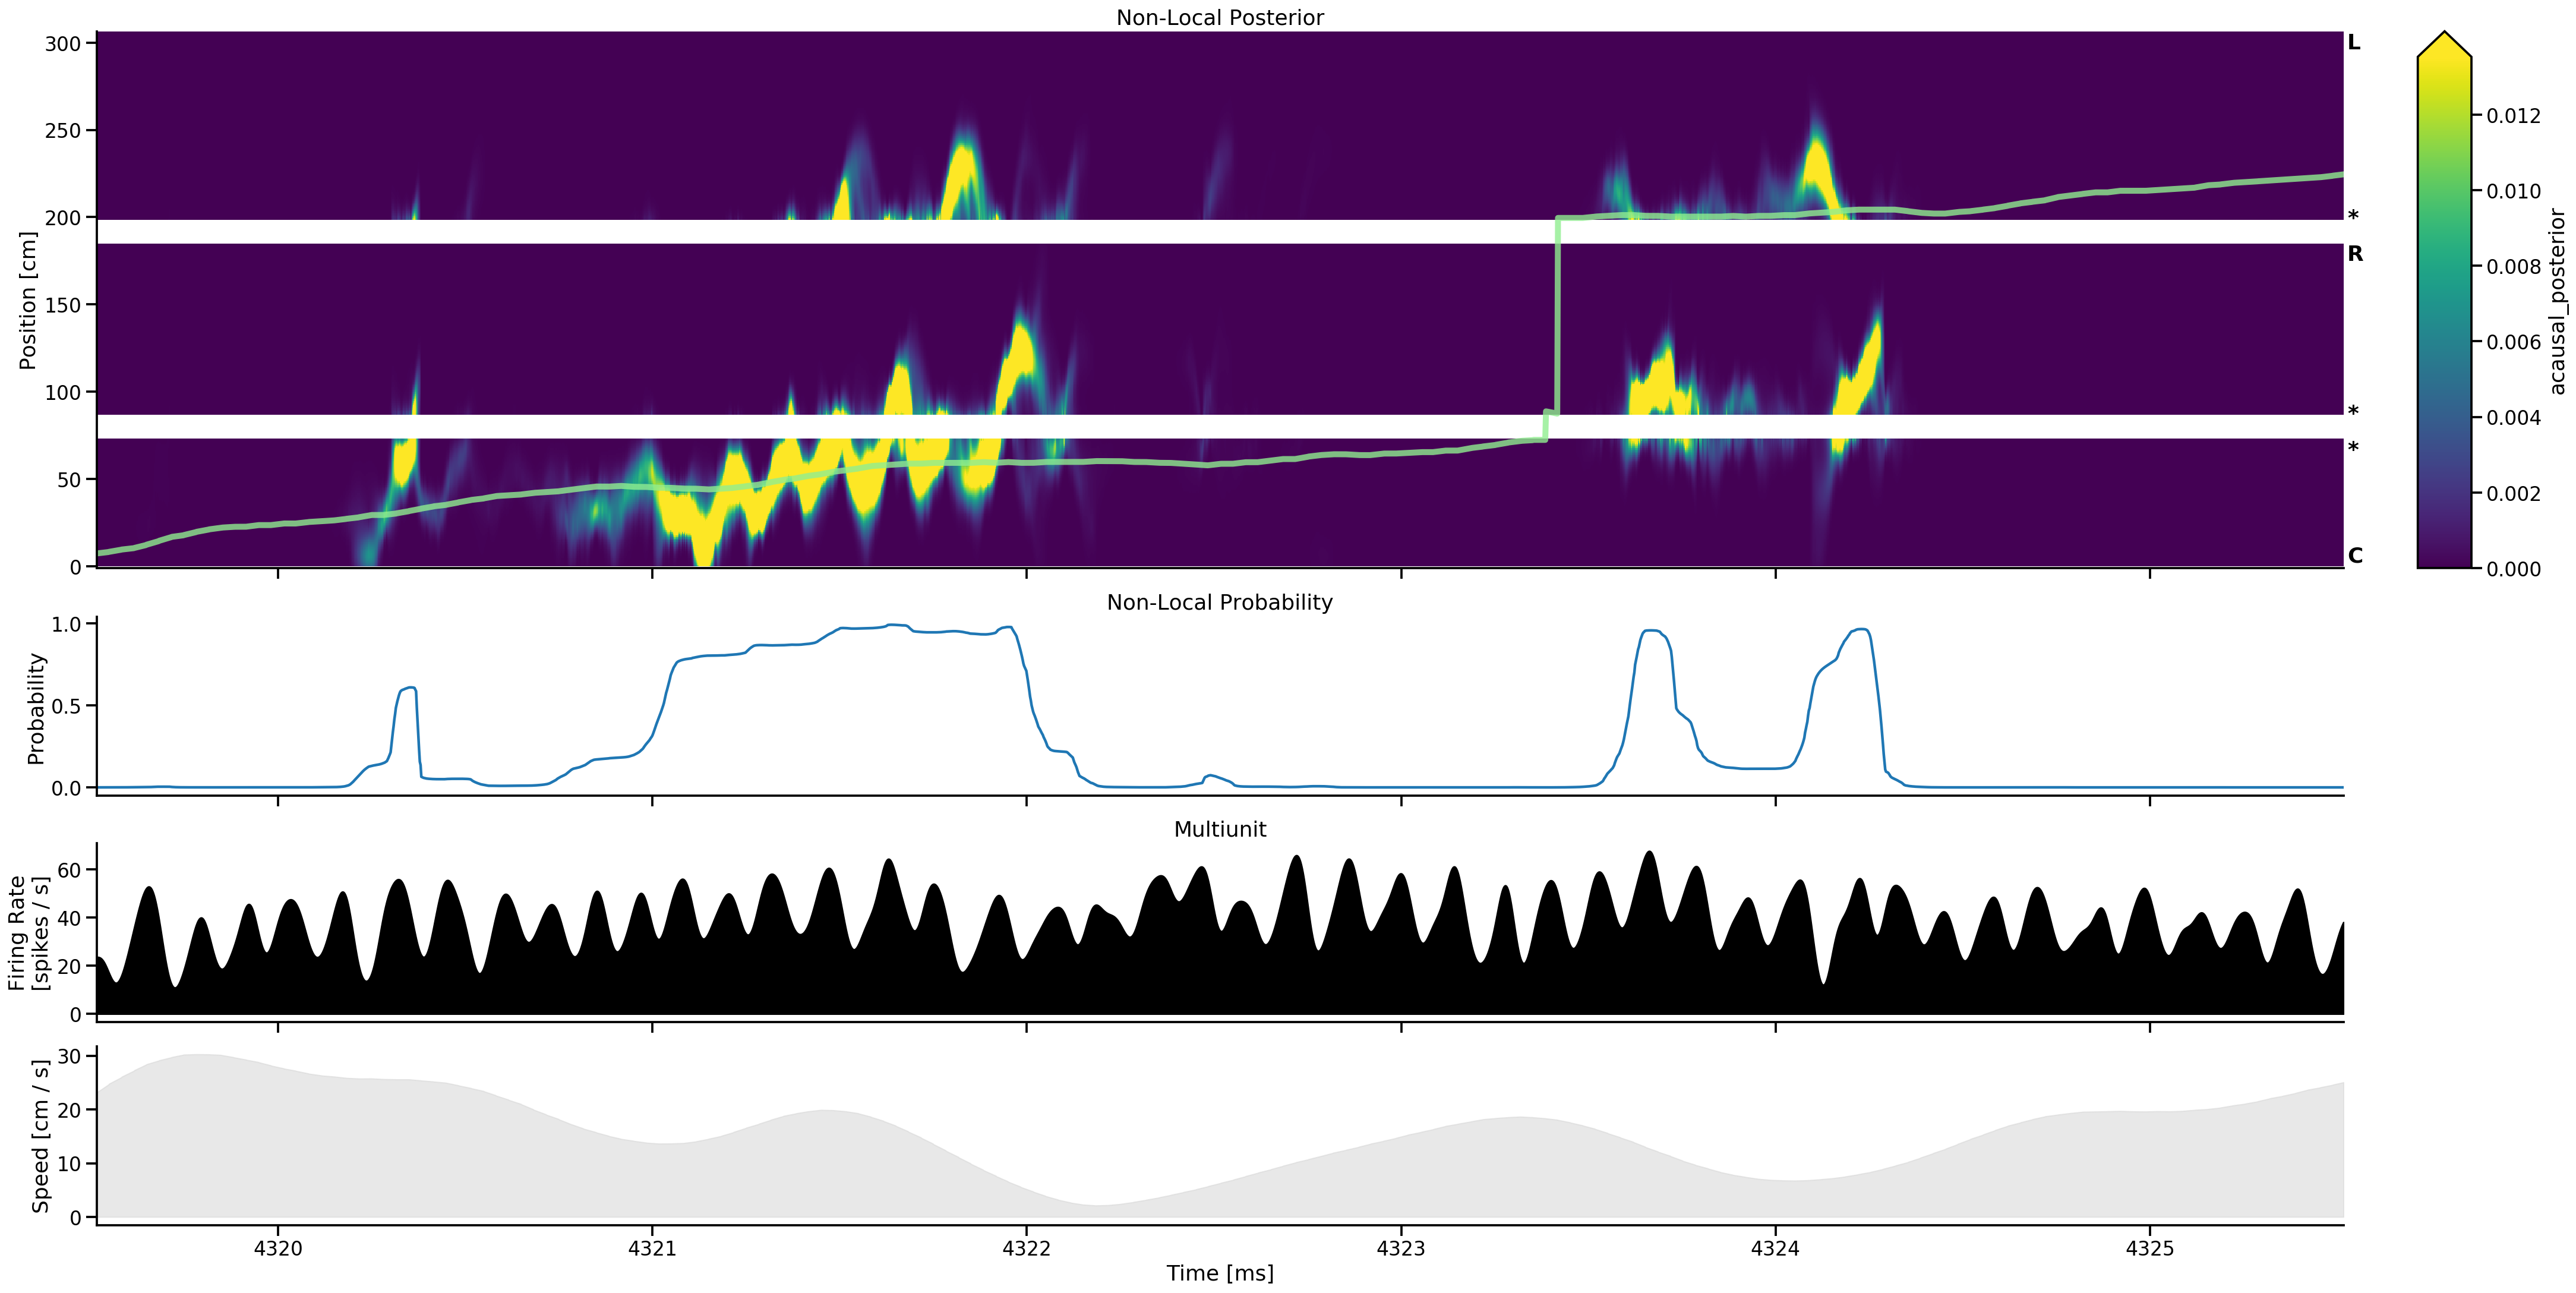

In [13]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 673.5, t.min() + 679.5)

plot_local_non_local_time_slice(time_slice, cv_detector, cv_clusterless_results, data)

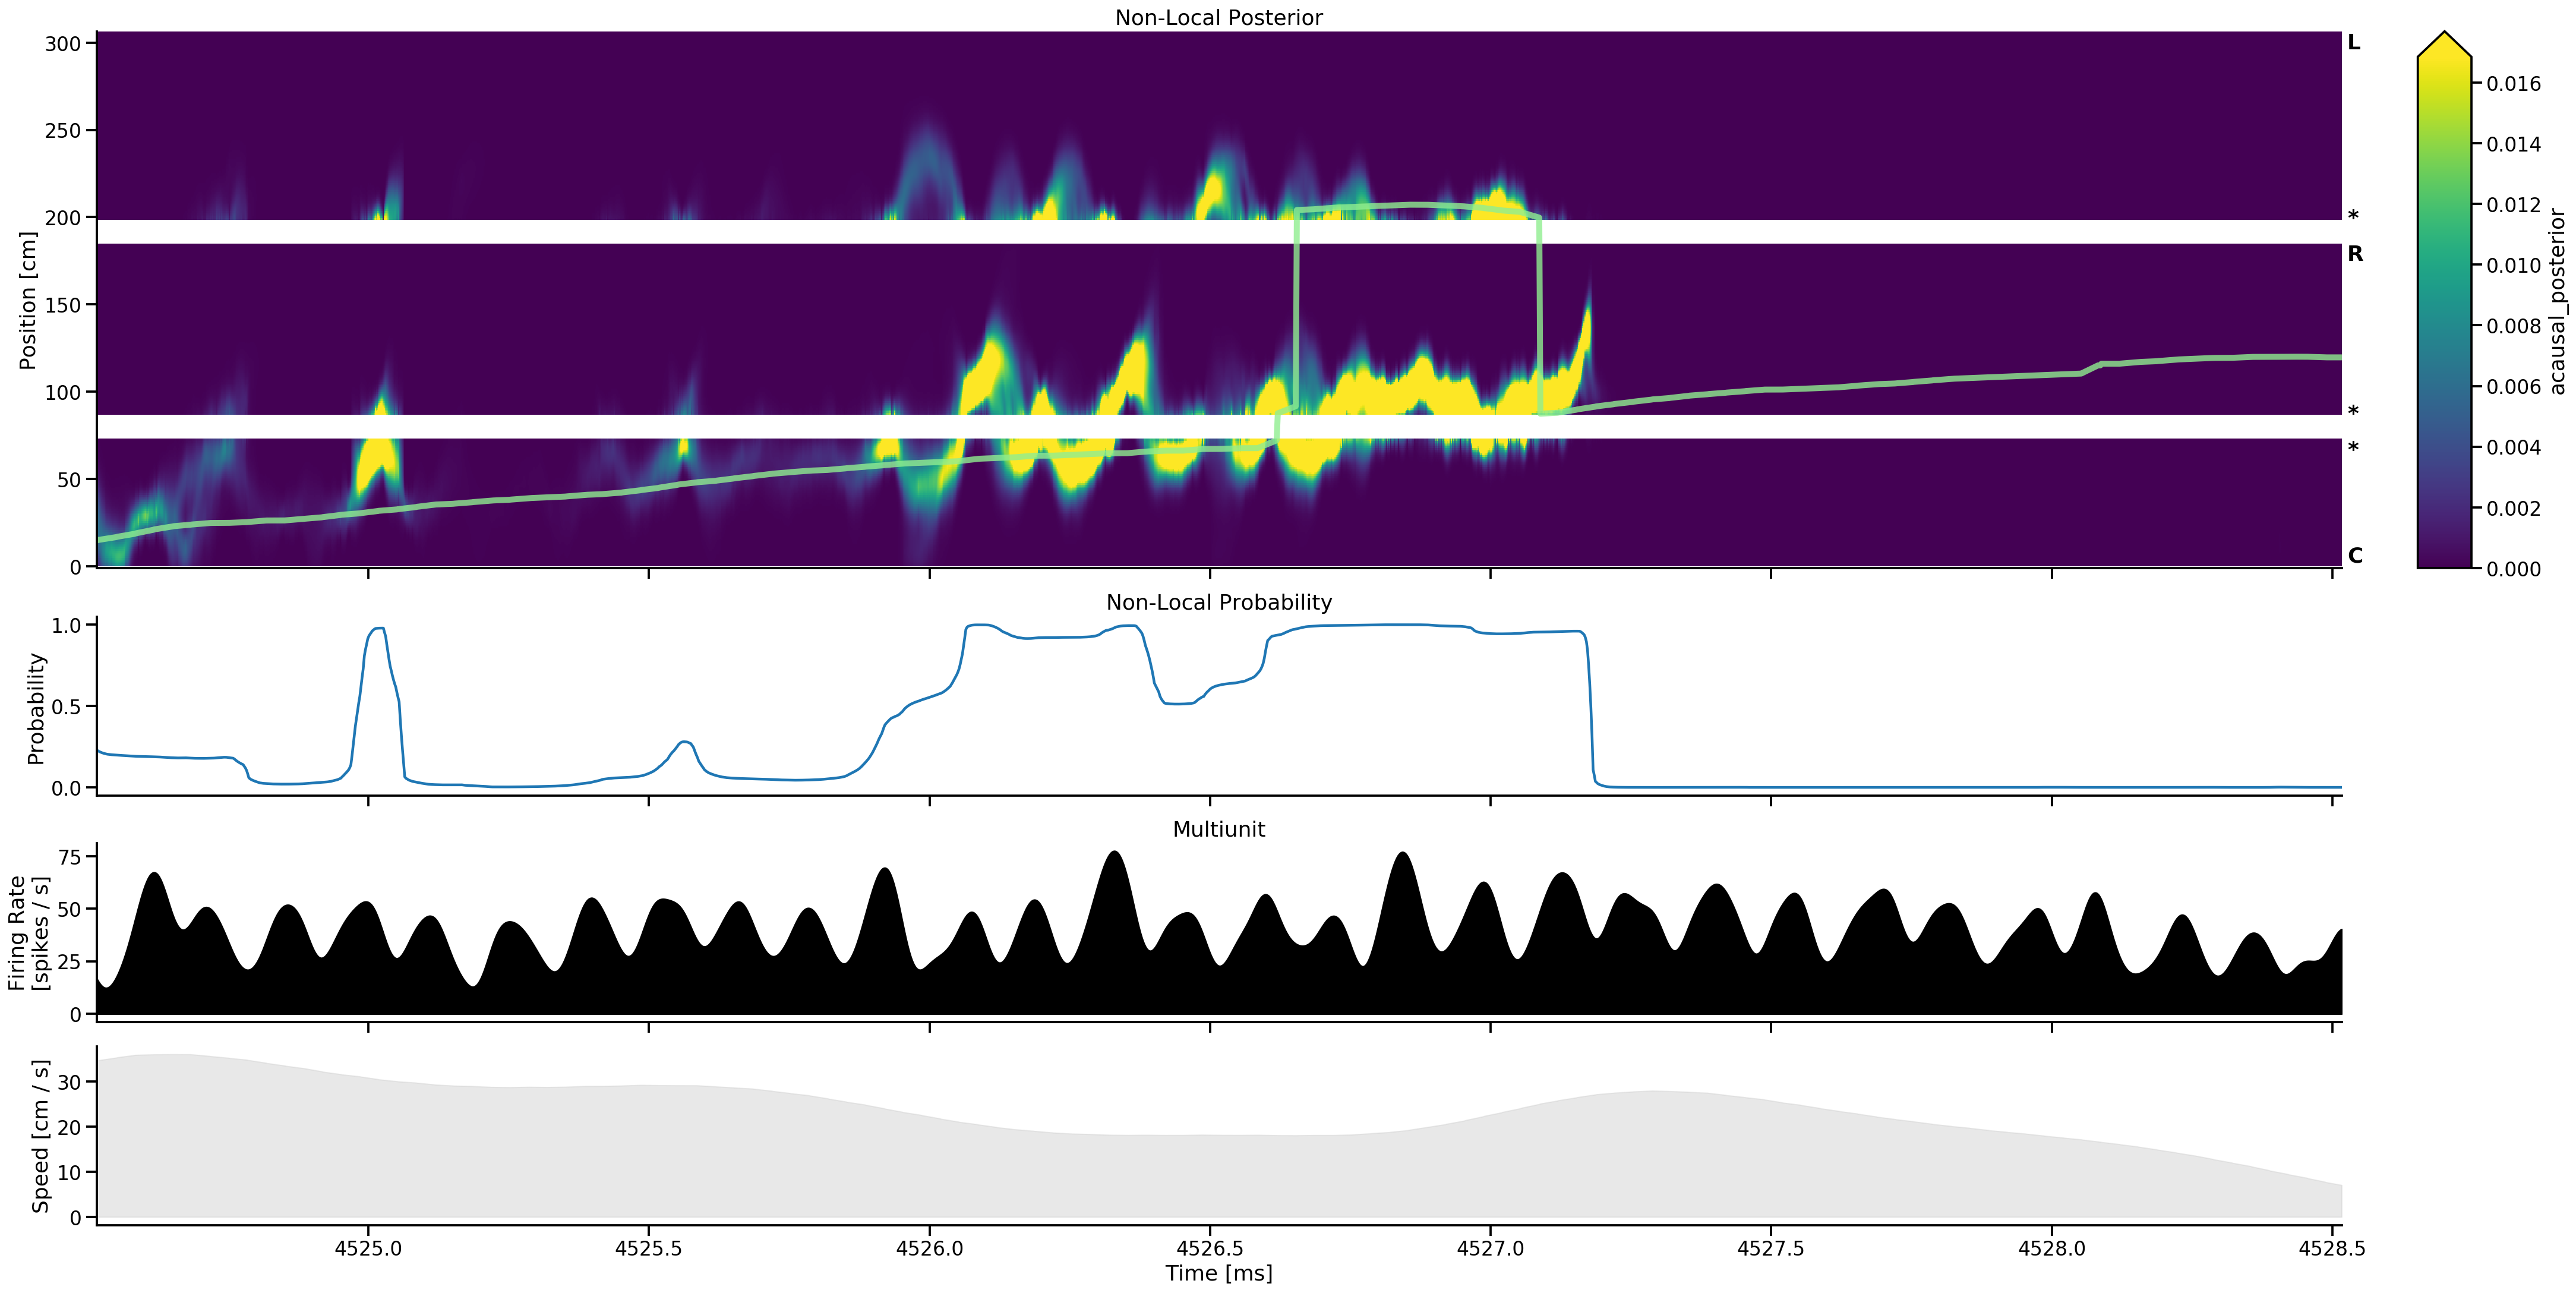

In [14]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 878.5, t.min() + 882.5)

plot_local_non_local_time_slice(time_slice, cv_detector, cv_clusterless_results, data)

#### Plot Casual

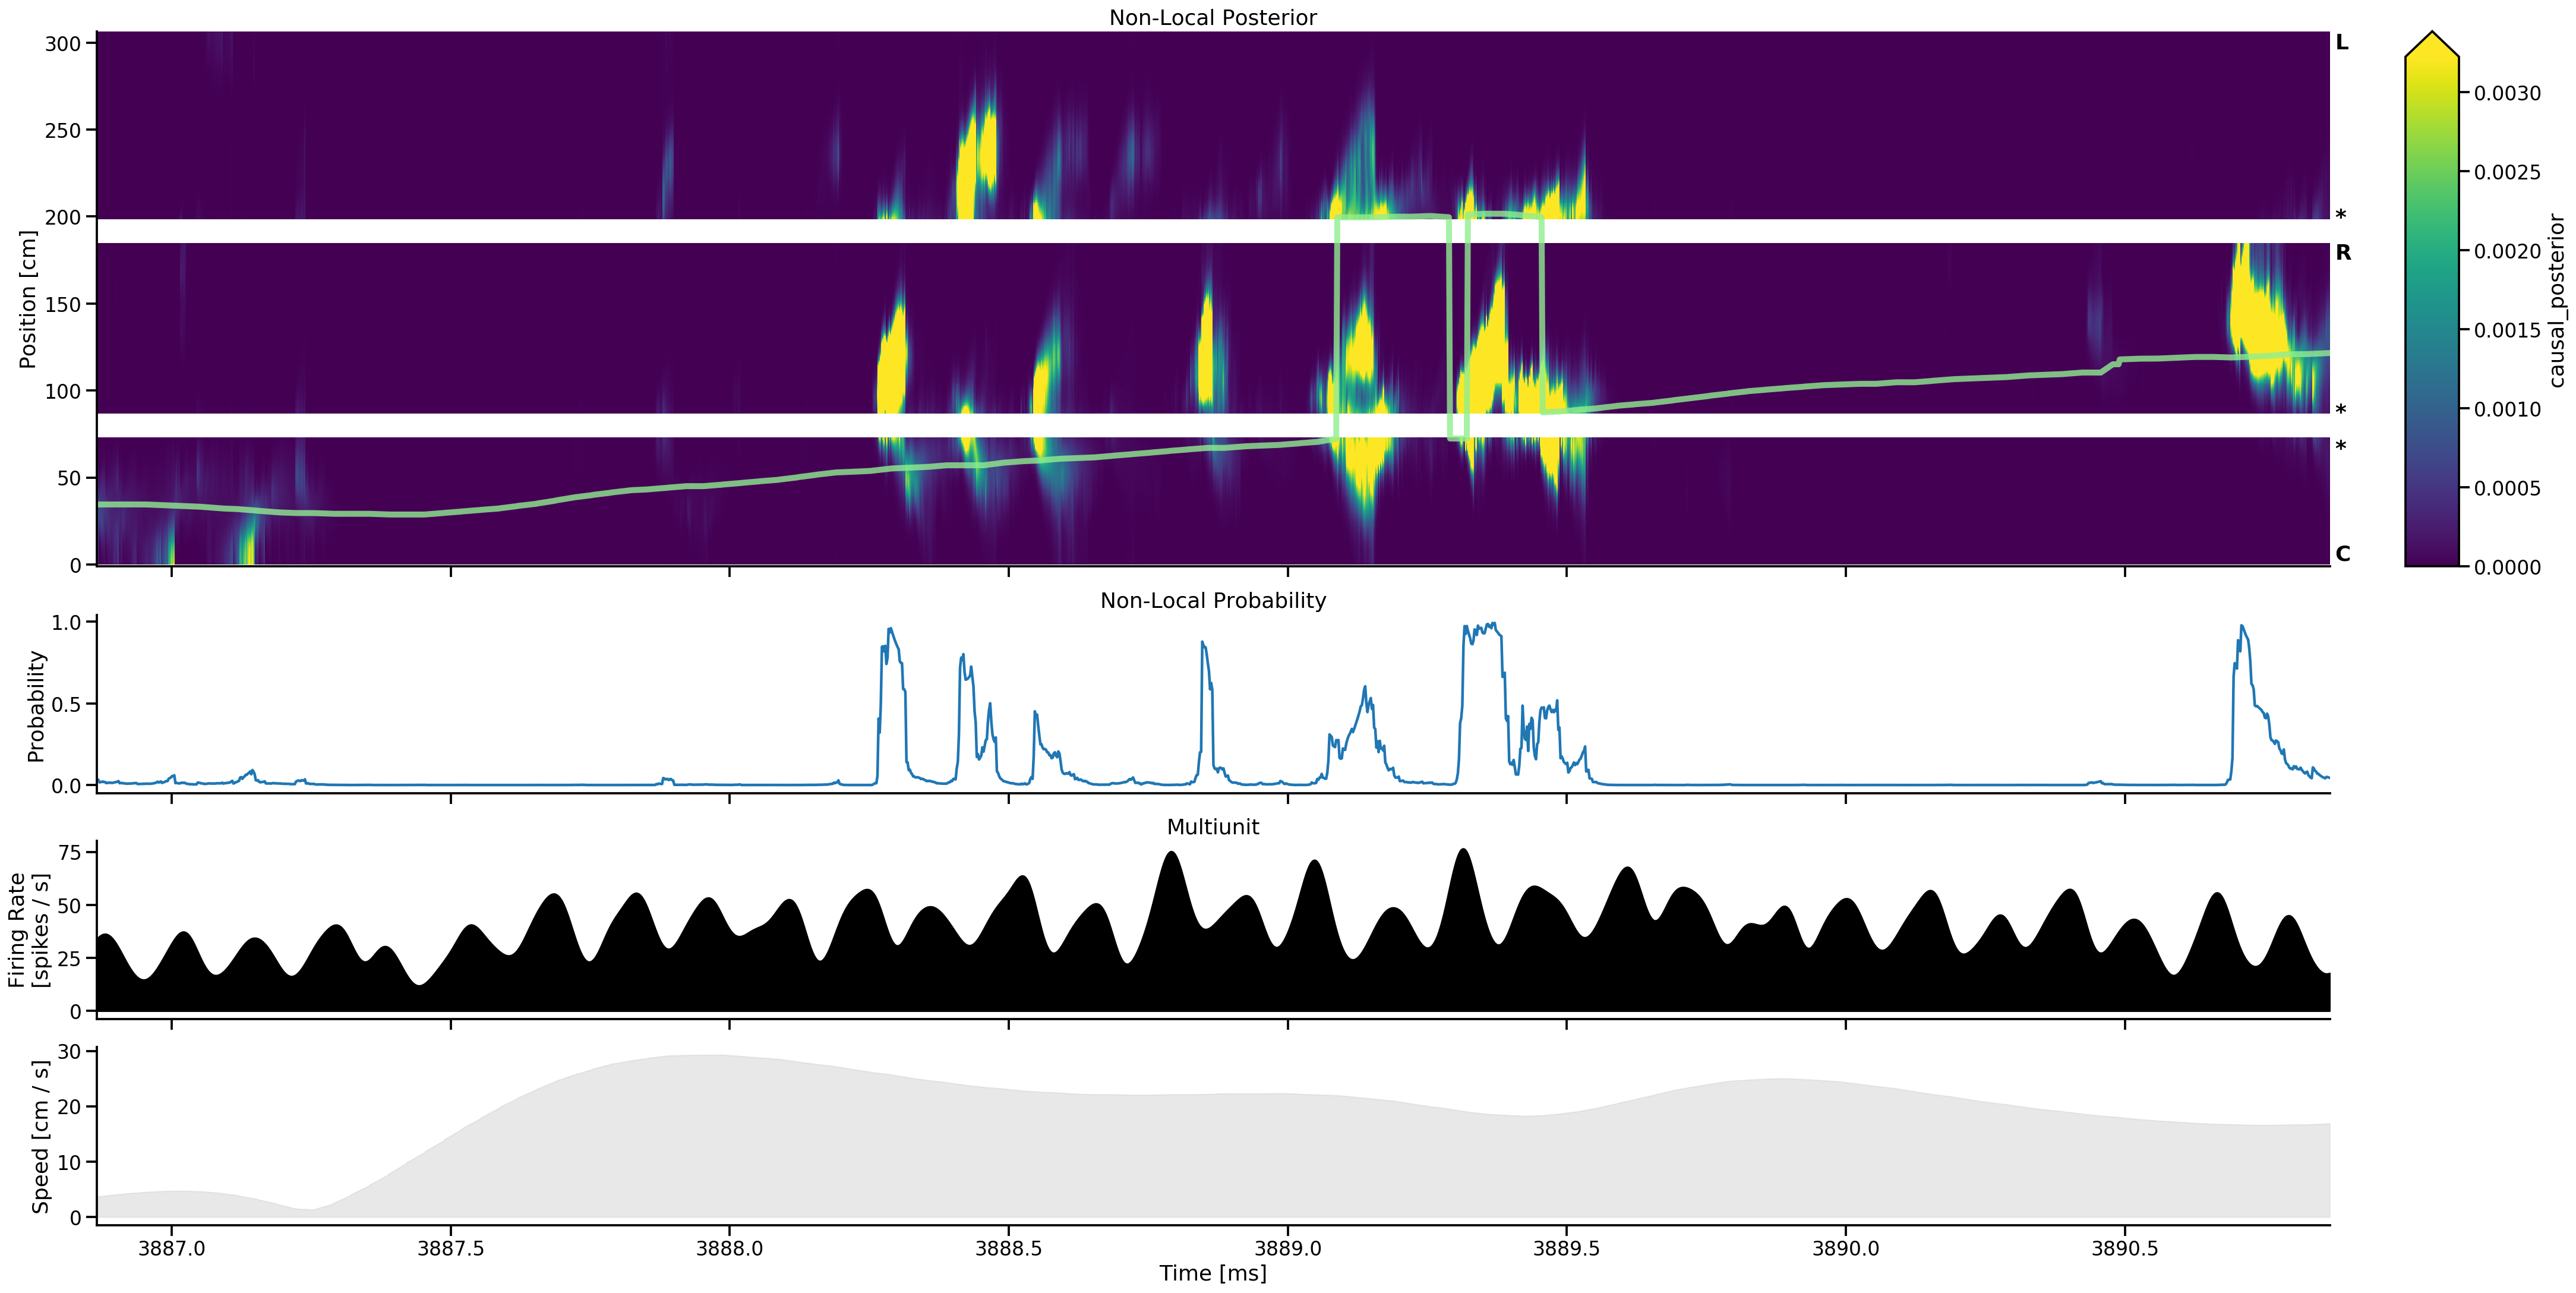

In [15]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 240.85, t.min() + 244.85)

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="causal_posterior",
)

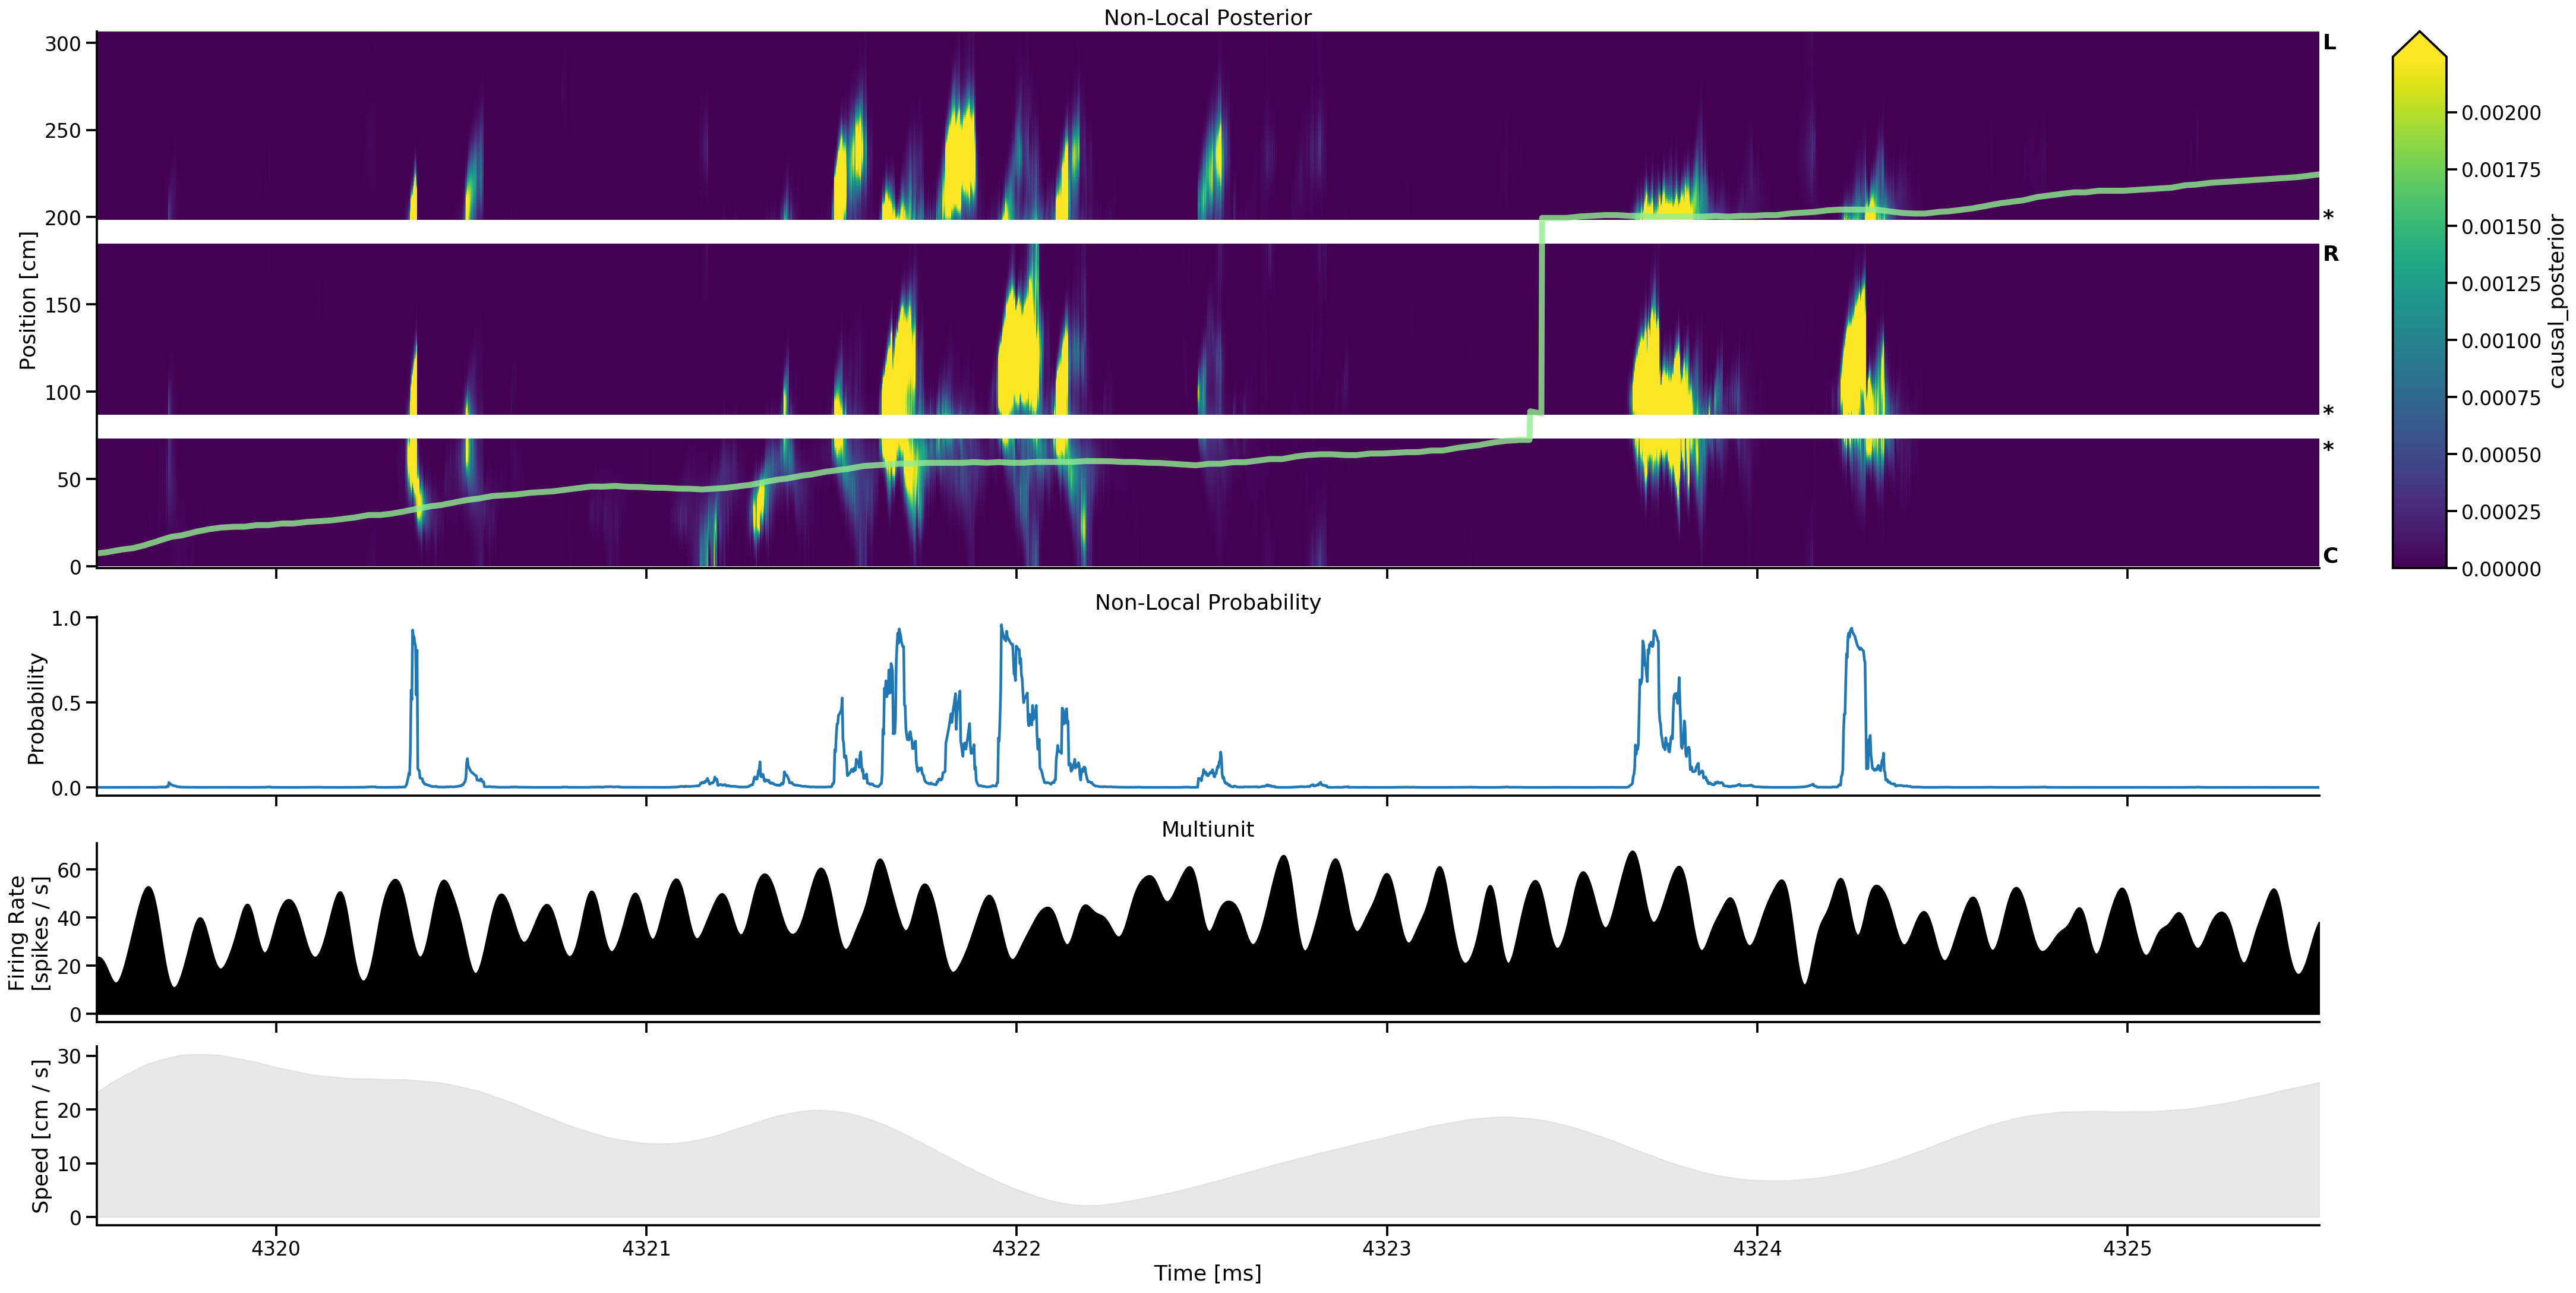

In [21]:
time_slice = slice(t.min() + 673.5, t.min() + 679.5)

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="causal_posterior",
)

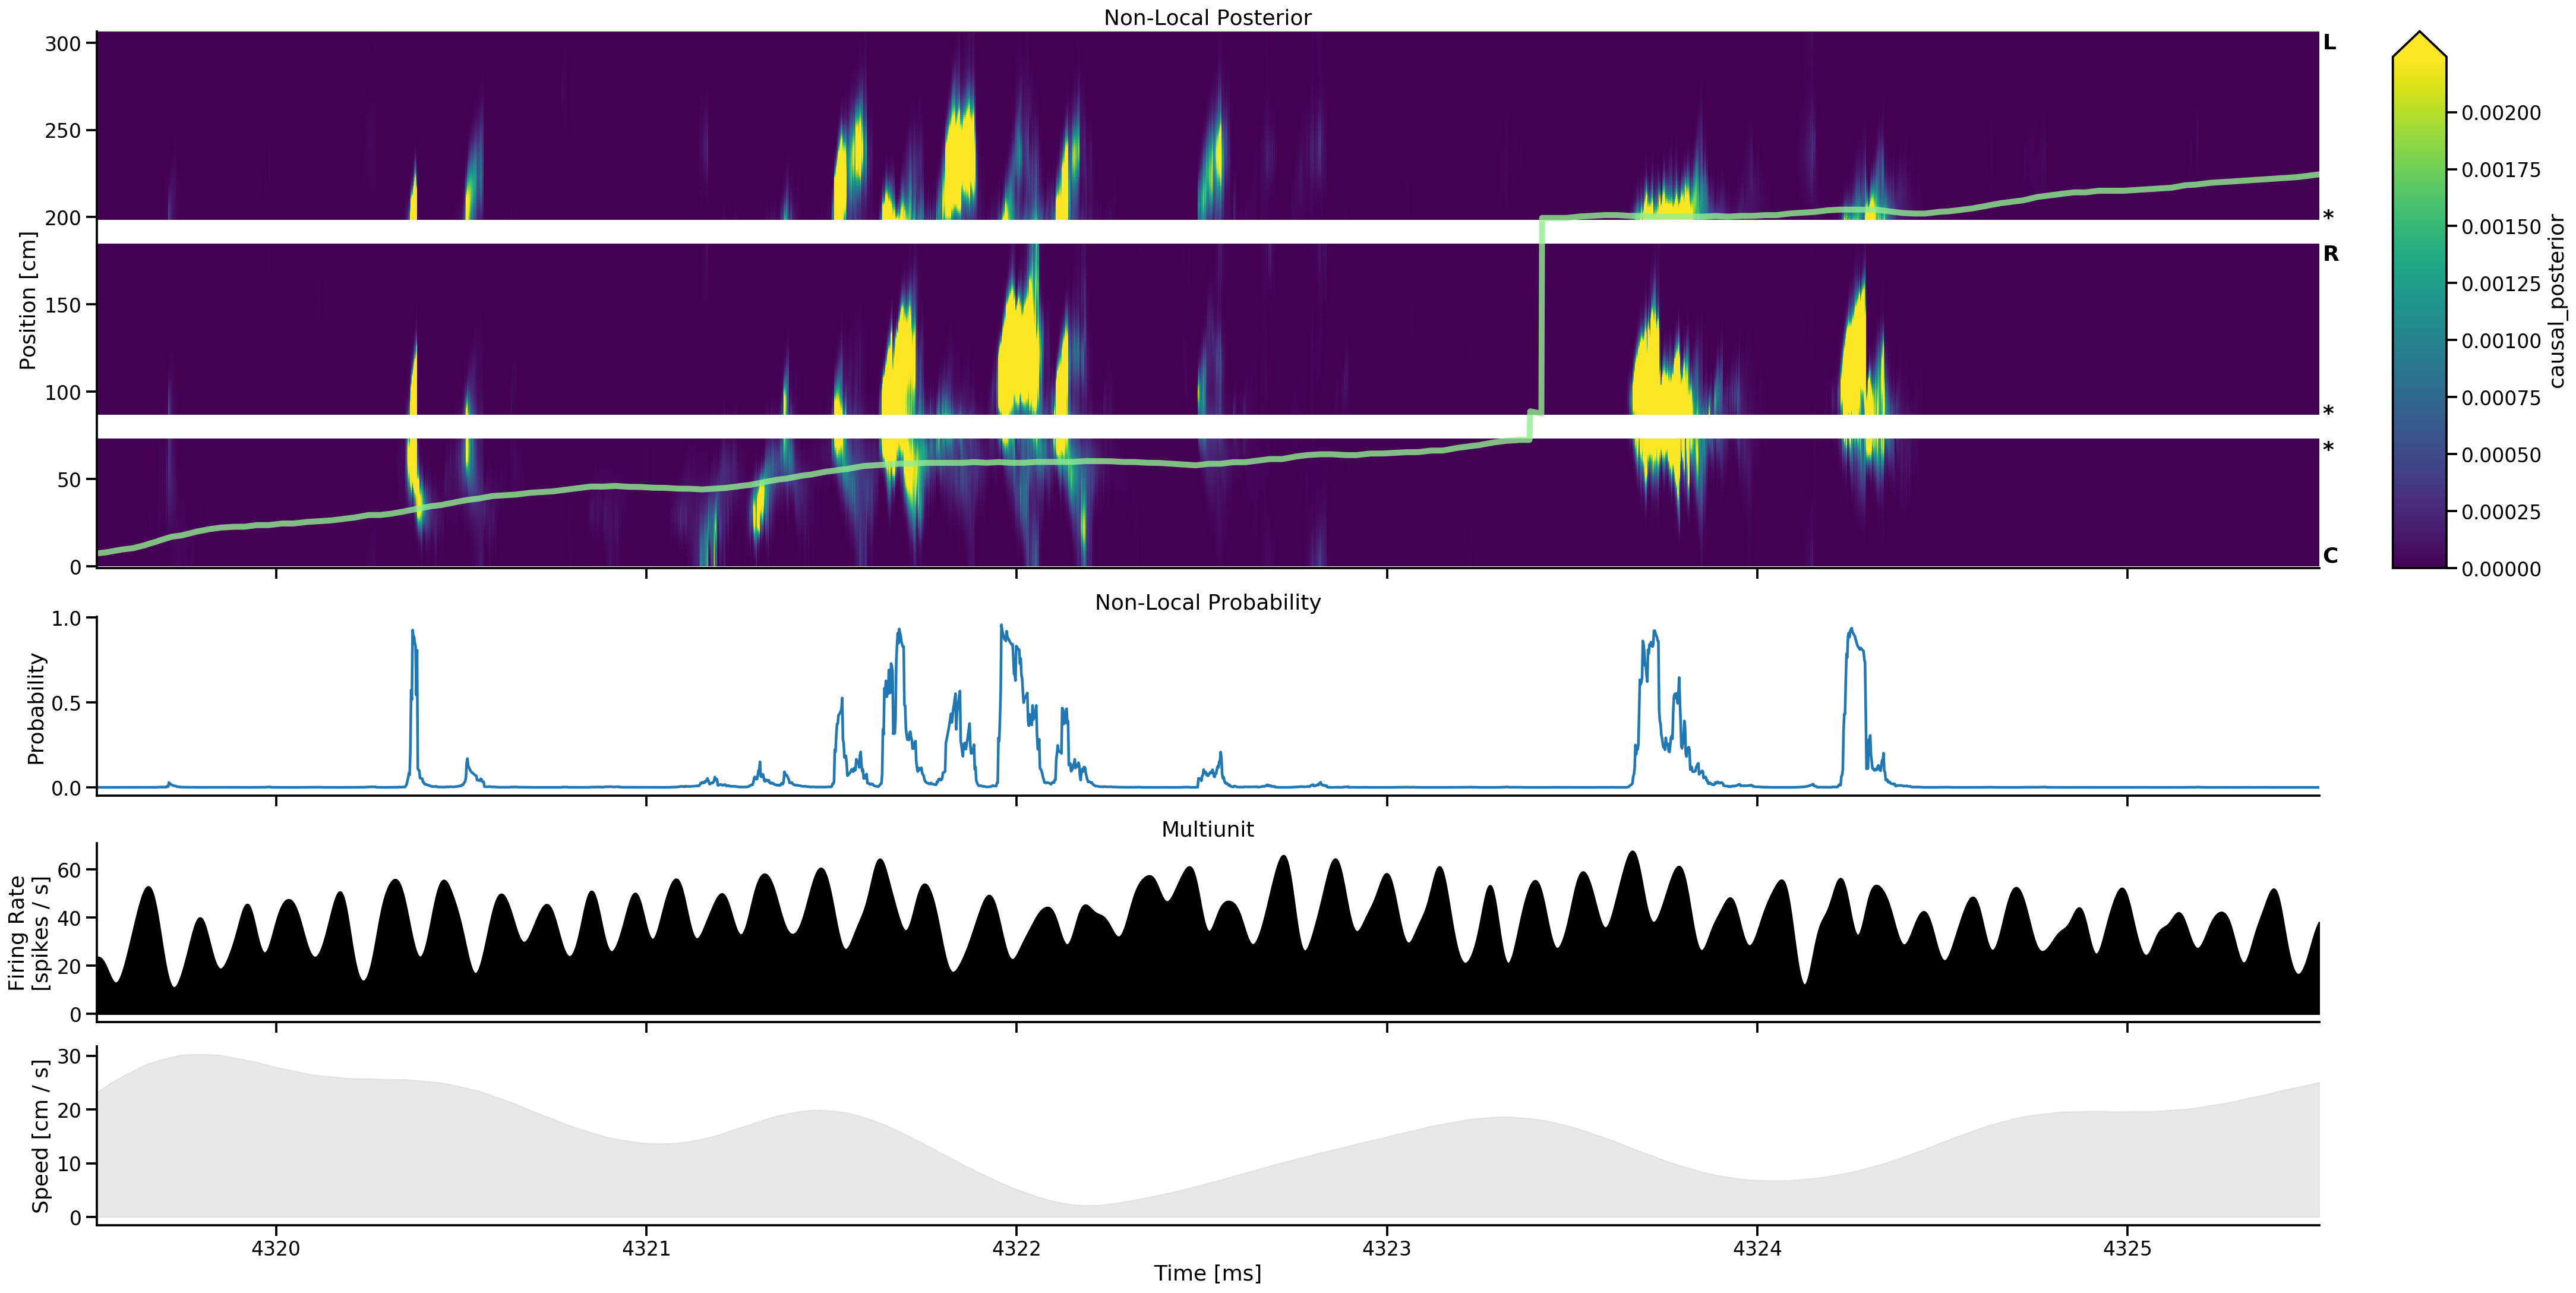

In [23]:
time_slice = slice(t.min() + 673.5, t.min() + 679.5)

plot_local_non_local_time_slice(
    time_slice,
    cv_detector,
    cv_clusterless_results,
    data,
    posterior_type="causal_posterior",
)

## Clusterless Classifier

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import classifier_parameters, discrete_state_transition

classifier = ClusterlessClassifier(**classifier_parameters)
track_labels = data['position_info'].arm_name

classifier.fit(position=data['position_info'].linear_position,
               multiunits=data['multiunits'],
               track_labels=track_labels, is_trainingis_runningunning)

classifier.discrete_state_transition_ = discrete_state_transition

clusterless_classifier_results = classifier.predict(data['multiunits'], time=data['multiunits'].time / np.timedelta64(1, "s"))